# Data Mining Project

## 1. Importing Libraries

In [345]:
import os
import json
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datasketch import MinHash
from collections import Counter
import matplotlib.pyplot as plt
from itertools import permutations
from geopy.distance import geodesic
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## 2. Data Loading

In [112]:
# Load the standard and actual routes data
with open('Dataset/standard_routes.json', 'r') as file:
    standard_routes = json.load(file)

with open('Dataset/actual_routes.json', 'r') as file:
    actual_routes = json.load(file)

## 3. Data Exploration and Analysis

In [3]:
# Analyzing the structure of the data
structure_standard = {"total_routes": len(standard_routes), "example_route": standard_routes[0]}
structure_actual = {"total_routes": len(actual_routes), "example_route": actual_routes[0]}

In [4]:
structure_standard

{'total_routes': 30,
 'example_route': {'id': 's1',
  'route': [{'from': 'Taranto',
    'to': 'Foggia',
    'merchandise': {'milk': 23, 'tomatoes': 16, 'pens': 42}},
   {'from': 'Foggia',
    'to': 'Pescara',
    'merchandise': {'butter': 22, 'coca-cola': 39, 'water': 19}},
   {'from': 'Pescara',
    'to': 'Rome',
    'merchandise': {'pens': 4, 'coffee': 8}}]}}

In [5]:
structure_actual

{'total_routes': 760,
 'example_route': {'id': 'a6782',
  'route': [{'from': 'Taranto',
    'to': 'Foggia',
    'merchandise': {'milk': 23, 'tomatoes': 16, 'pens': 42}},
   {'from': 'Foggia',
    'to': 'Pescara',
    'merchandise': {'butter': 22, 'coca-cola': 39, 'water': 19}},
   {'from': 'Pescara',
    'to': 'Giugliano in Campania',
    'merchandise': {'pens': 4, 'coffee': 8}}],
  'sroute': 's1',
  'driver': 'D27'}}

In [113]:
# Data Cleaning Example: Normalize city names
def normalize_city_names(city):
    if "-" in city:
        city = city.replace("-", " ")
        
    return city.strip().lower().replace(" ", "_")

def normalize_merchant_names(merchants):
    return {normalize_city_names(merchant): qty for merchant, qty in merchants.items()}

def convert_merchandise_quantities(merchandise):
    return {item: int(qty) for item, qty in merchandise.items()}

def normalize_trip(trip):
    return {
        "from": normalize_city_names(trip["from"]),
        "to": normalize_city_names(trip["to"]),
        "merchandise": convert_merchandise_quantities(trip["merchandise"])
    }

def normalize_route(route):
    return [normalize_trip(trip) for trip in route]

def normalize_routes(routes):
    return [normalize_route(route) for route in routes]

def normalize_data(data, type_):
    if type_ == "standard":
        return {
            "s_id": data["id"],
            "route": normalize_route(data["route"])
        }
    elif type_ == "actual":
        return {
            "a_id": data["id"],
            "driver": data["driver"],
            "s_id": data["sroute"],
            "route": normalize_route(data["route"])
        }
    else:
        raise ValueError("Invalid type_ value. Valid values are 'standard' and 'actual'")
    
def normalize_standard_routes(standard_routes_):
    return [normalize_data(route, "standard") for route in standard_routes_]

def normalize_actual_routes(actual_routes_):
    return [normalize_data(route, "actual") for route in actual_routes_]

standard_routes_df = pd.DataFrame(normalize_standard_routes(standard_routes))
actual_routes_df = pd.DataFrame(normalize_actual_routes(actual_routes))

In [114]:
standard_routes_df.head()

,s_id,route
0,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand..."
1,s2,"[{'from': 'forlì', 'to': 'ferrara', 'merchandi..."
2,s3,"[{'from': 'piacenza', 'to': 'parma', 'merchand..."
3,s4,"[{'from': 'naples', 'to': 'giugliano_in_campan..."
4,s5,"[{'from': 'monza', 'to': 'parma', 'merchandise..."


In [116]:
actual_routes_df.head()

,a_id,driver,s_id,route
0,a6782,D27,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand..."
1,a6782,D27,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand..."
2,a49803,D42,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand..."
3,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand..."
4,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand..."


In [117]:
# Finding the number of actual routes for each driver and standard route
actual_routes_count = actual_routes_df.groupby(['driver', 's_id']).size().reset_index(name='count')
actual_routes_count.sample(10)

,driver,s_id,count
243,D42,s20,3
171,D31,s22,2
51,D16,s21,8
215,D38,s23,1
335,D9,s8,3
23,D11,s8,1
233,D40,s19,2
65,D18,s14,1
316,D6,s30,1
222,D39,s5,3


<Axes: xlabel='driver'>

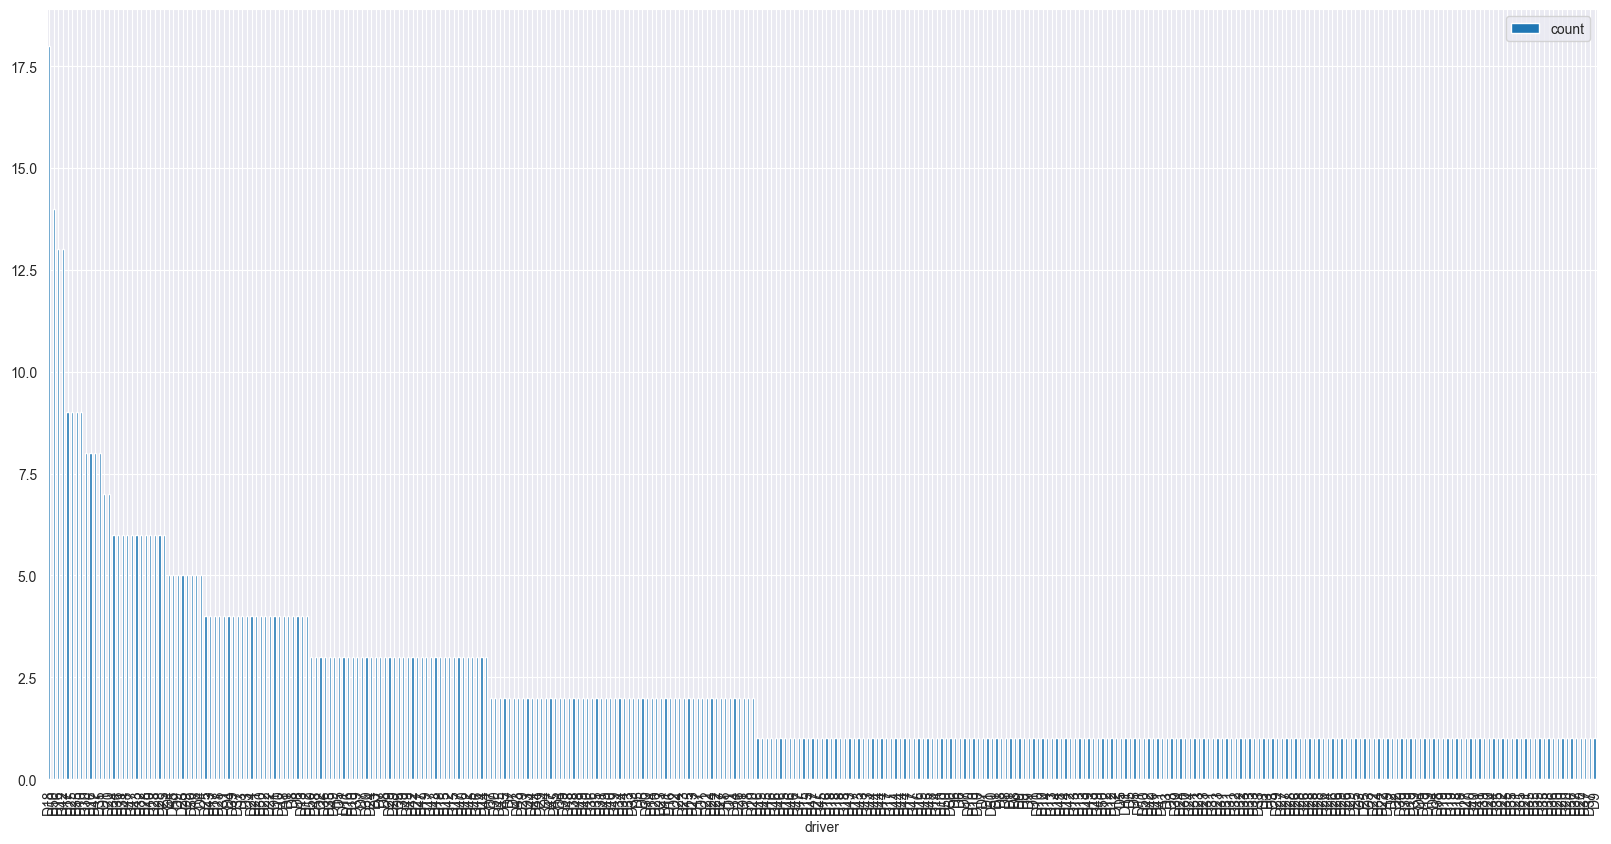

In [118]:
# Show the graph for number of actual routes for each driver and standard route using a bar chart and should be sorted in descending order
actual_routes_count.sort_values(by='count', ascending=False).plot.bar(x='driver', y='count', figsize=(20, 10))

In [119]:
# Finding the number of drivers for each standard route
standard_routes_count = actual_routes_count.groupby('s_id').size().reset_index(name='count')
standard_routes_count

,s_id,count
0,s1,9
1,s10,11
2,s11,15
3,s12,13
4,s13,12
5,s14,9
6,s15,11
7,s16,9
8,s17,13
9,s18,11


In [120]:
# Finding the number of standard routes for each driver
driver_routes_count = actual_routes_count.groupby('driver').size().reset_index(name='count')
driver_routes_count.sample(10)

,driver,count
3,D12,4
35,D41,3
11,D2,4
29,D36,5
48,D8,6
27,D34,5
15,D23,6
5,D14,7
43,D49,7
38,D44,9


## 4. Routes Statistics

In [122]:
def route_to_string(route_):
    """
    Convert a route (list of leg dictionaries) to a standardized string format.
    
    @param route_: list of leg (trips) dictionaries. (A route is a list of trips from one location to another with merchandise)
    
    @return: string representation of the route
    """
    return ' '.join(["{}-{}".format(leg['from'], leg['to']) for leg in route_])

def calculate_drivers_actual_route_statistics(driver_routes, std_route_dict):
    """
    Calculate statistics for a driver's routes.
    
    @param driver_routes: DataFrame containing the driver's routes
    @param std_route_dict: dictionary mapping standard route IDs to their route strings
    
    @return: dictionary containing the statistics (total_actual_routes, same_varied_actual_routes, same_std_route, different_varied_actual_routes)
    """
    same_varied_actual_routes = Counter()  # Number of actual routes that are the same as another actual route
    different_varied_actual_routes = 0  # Number of actual routes that are different from the standard route
    same_std_route = 0  # Number of actual routes that are the same as the standard route
    
    for _, route_row in driver_routes.iterrows():
        # get the standard route from the dictionary using the standard route ID from the actual route of driver
        std_route = std_route_dict.get(route_row['s_id'], "")
        
        # get the actual route followed by the driver as a string ignoring the merchandise
        act_route = route_to_string(route_row['route'])  
        
        same_varied_actual_routes.update([act_route])  # update the counter for the actual route
        if act_route == std_route:  # if the actual route is the same as the standard route
            same_std_route += 1
        else:  # if the actual route is different from the standard route
            different_varied_actual_routes += 1
    
    # get the number of actual routes that are the same as another actual route
    repeated_actual_routes = sum(1 for count in same_varied_actual_routes.values() if count > 1)
    
    return {
        'total_actual_routes': len(driver_routes),
        'same_varied_actual_routes': repeated_actual_routes,
        'same_std_route': same_std_route,
        'different_varied_actual_routes': different_varied_actual_routes - repeated_actual_routes
    }

def analyze_driver_routes(actual_routes_df_, standard_routes_df_):
    """
    Analyze routes for all drivers.
    
    @param actual_routes_df_: DataFrame containing the actual routes
    @param standard_routes_df_: DataFrame containing the standard routes
    
    @return: dictionary mapping driver IDs to their route statistics
    """
    driver_actual_routes_analysis = {}

    # Create a dictionary mapping standard route IDs to their route strings
    std_route_dict = {row['s_id']: route_to_string(row['route']) for _, row in standard_routes_df_.iterrows()}

    for driver_ in actual_routes_df_['driver'].unique():
        driver_routes = actual_routes_df_[actual_routes_df_['driver'] == driver_]
        driver_actual_routes_analysis[driver_] = calculate_drivers_actual_route_statistics(driver_routes, std_route_dict)

    return driver_actual_routes_analysis

In [124]:
# Use the analyze_driver_routes function to get the analysis
driver_actual_routes_followed_analysis = analyze_driver_routes(actual_routes_df, standard_routes_df)

# Convert the analysis to a DataFrame
driver_actual_routes_followed_analysis_df = pd.DataFrame(driver_actual_routes_followed_analysis).T

driver_actual_routes_followed_analysis_df.sample(10)

,total_actual_routes,same_varied_actual_routes,same_std_route,different_varied_actual_routes
D22,15,4,5,6
D5,10,3,8,-1
D46,7,1,5,1
D36,13,3,2,8
D19,10,1,7,2
D42,24,4,2,18
D3,20,4,13,3
D16,30,3,13,14
D23,9,3,2,4
D21,6,1,0,5


<Axes: >

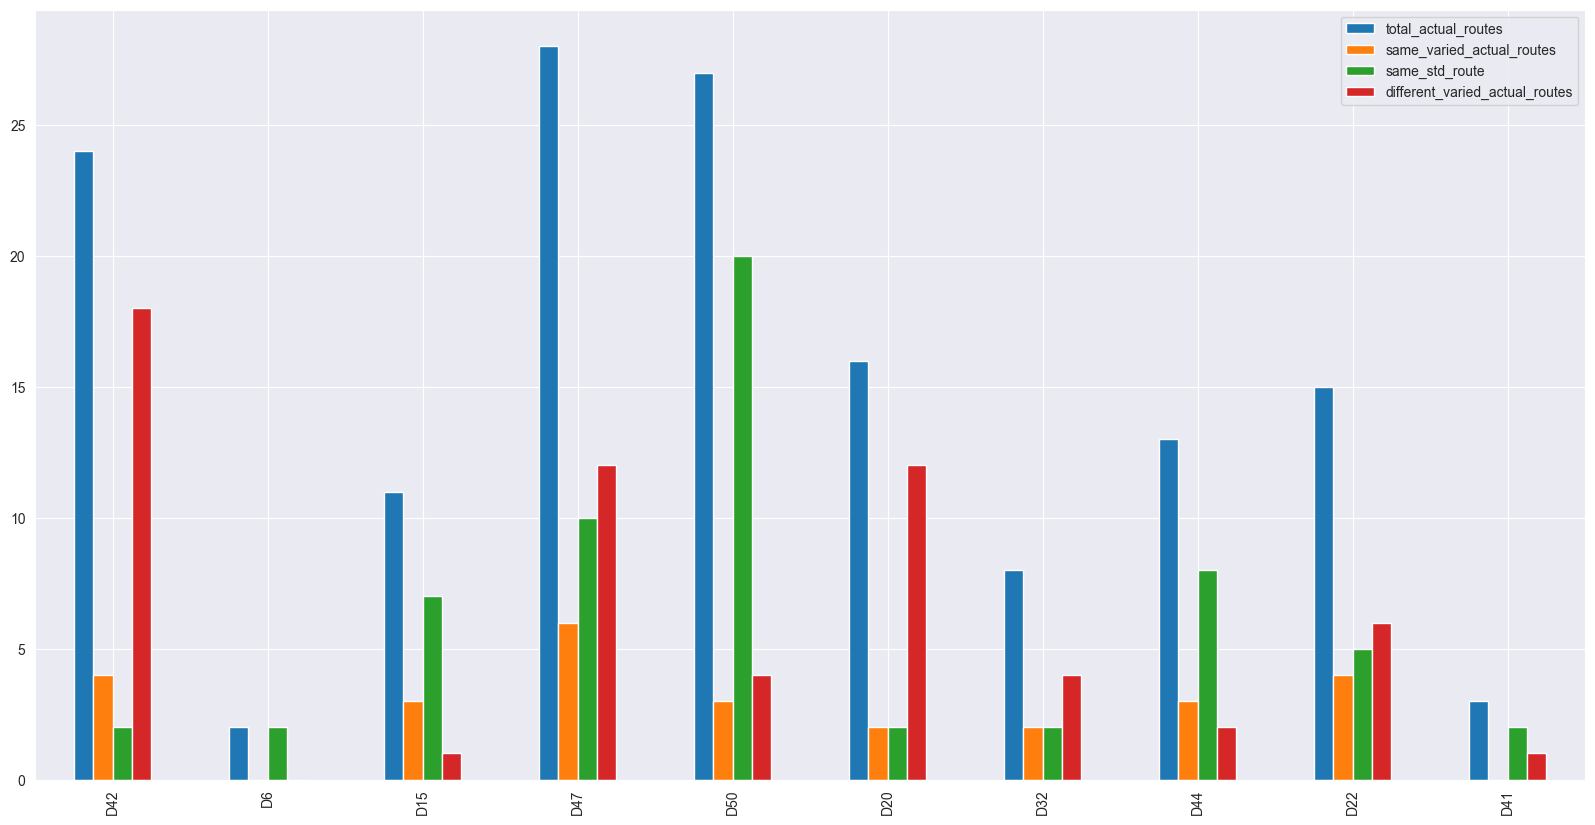

In [127]:
# Randomly plot analysis for 10 drivers
random_drivers = random.sample(list(driver_actual_routes_followed_analysis.keys()), 10)
driver_actual_routes_followed_analysis_df.loc[random_drivers].plot.bar(figsize=(20, 10))

## 5. Data Preprocessing and Encoding (Vectorization)

### 5.1 RouteDataProcessor

In [2]:
# DataLoader class
class RouteDataProcessor:
    """
    A class to load the data and create vocabulary.
    """

    def __init__(self, std_routes_path, act_routes_path, normalize=True):
        """
        Initialize the DataLoader class.

        @param std_routes_path: path to the standard routes file
        @param act_routes_path: path to the actual routes file
        @param normalize: whether to normalize the data (default: True)
        """
        ###############################################################
        # Loading the data
        ###############################################################
        # Load the standard and actual routes data
        with open(std_routes_path, 'r') as file_:
            standard_routes_ = json.load(file_)
        
        with open(act_routes_path, 'r') as file_:
            actual_routes_ = json.load(file_)
        ###############################################################
        # Data Preprocessing
        ###############################################################
        if normalize:
            # Normalize the data
            standard_routes_ = self.normalize_standard_routes(standard_routes_)
            actual_routes_ = self.normalize_actual_routes(actual_routes_)
            
        # Create standard and actual routes dataframes
        self.standard_routes_df = pd.DataFrame(standard_routes_)
        self.standard_routes_df['type'] = 'standard'
        self.actual_routes_df = pd.DataFrame(actual_routes_)
        self.actual_routes_df['type'] = 'actual'

        # create cities and trips sequences for each route
        self.standard_routes_df['cities_sequence'] = self.standard_routes_df['route'].apply(
            self.get_route_cities_sequence)
        self.standard_routes_df['trips_sequence'] = self.standard_routes_df['route'].apply(self.get_trips_sequence)

        self.actual_routes_df['cities_sequence'] = self.actual_routes_df['route'].apply(self.get_route_cities_sequence)
        self.actual_routes_df['trips_sequence'] = self.actual_routes_df['route'].apply(self.get_trips_sequence)

        ###############################################################
        # Build the vocabulary
        ###############################################################
        self.cities = set()
        self.cities_pair = set()
        self.trips = set()
        self.merchandise = set()
        self.drivers = set()

        self.max_trip = 0  # Maximum number of trips across all routes
        self.minimum_quantity = float('inf')  # min. qty merchandise across all routes
        self.maximum_quantity = 0  # max. qty merchandise across all routes
        self.vocabulary_size = 0  # size of the vocabulary

        self.city2id = {}
        self.id2city = {}
        self.cities_pair2id = {}
        self.id2cities_pair = {}
        self.trip2id = {}
        self.id2trip = {}
        self.merchandise2id = {}
        self.id2merchandise = {}
        self.driver2id = {}
        self.id2driver = {}

        # Build the vocabulary
        self._build_vocabulary(self.standard_routes_df)
        self._build_vocabulary(self.actual_routes_df)
        ###############################################################
        # Create mappings
        ###############################################################
        self._create_mappings()
        
    @staticmethod
    def normalize_city_names(city):
        if "-" in city:
            city = city.replace("-", " ")

        return city.strip().lower().replace(" ", "_")

    @staticmethod
    def convert_merchandise_quantities(merchandise):
        return {item: int(qty) for item, qty in merchandise.items()}

    @staticmethod
    def normalize_routes(self, routes):
        return [self.normalize_route(route) for route in routes]
    
    @staticmethod
    def get_route_cities_sequence(route):
        """
        Get the sequence of cities in a route.
        e.g. route: [{'from': 'city1', 'to': 'city2'}, {'from': 'city2', 'to': 'city3'}, {'from': 'city3', 'to': 'city4'}]
        cities_sequence: ['city1', 'city2', 'city3', 'city4']

        @param route: route

        @return: sequence of cities in the route
        """
        cities_sequence = []
        for trip in route:
            if len(cities_sequence) == 0:
                cities_sequence.append(trip['from'])
                cities_sequence.append(trip['to'])
            else:
                cities_sequence.append(trip['to'])

        return cities_sequence

    @staticmethod
    def get_trips_sequence(route):
        """
        Get the sequence of city pairs in a route.
        e.g. route: [{'from': 'city1', 'to': 'city2'}, {'from': 'city2', 'to': 'city3'}, {'from': 'city3', 'to': 'city4'}]
        cities_pair_sequence: ['city1-city2', 'city2-city3', 'city3-city4']

        @param route: route

        @return: sequence of city pairs in the route
        """
        cities_pair_sequence = []
        for trip in route:
            cities_pair_sequence.append(
                tuple(
                    [trip['from']] +
                    [trip['to']] +
                    [(merch, qty) for merch, qty in trip['merchandise'].items()]
                )
            )

        return cities_pair_sequence
    
    def normalize_merchant_names(self, merchants):
        return {self.normalize_city_names(merchant): qty for merchant, qty in merchants.items()}
    
    def normalize_trip(self, trip):
        return {
            "from": self.normalize_city_names(trip["from"]),
            "to": self.normalize_city_names(trip["to"]),
            "merchandise": self.convert_merchandise_quantities(trip["merchandise"])
        }
    
    def normalize_route(self, route):
        return [self.normalize_trip(trip) for trip in route]
    
    def normalize_data(self, data, type_):
        if type_ == "standard":
            return {
                "s_id": data["id"],
                "route": self.normalize_route(data["route"])
            }
        elif type_ == "actual":
            return {
                "a_id": data["id"],
                "driver": data["driver"],
                "s_id": data["sroute"],
                "route": self.normalize_route(data["route"])
            }
        else:
            raise ValueError("Invalid type_ value. Valid values are 'standard' and 'actual'")
        
    def normalize_standard_routes(self, standard_routes_):
        return [self.normalize_data(route, "standard") for route in standard_routes_]
    
    def normalize_actual_routes(self, actual_routes_):
        return [self.normalize_data(route, "actual") for route in actual_routes_]
    
    def _build_vocabulary(self, routes_df_):
        """
        Build the vocabulary.
        """
        # Iterate through each route
        for _, row in routes_df_.iterrows():
            # Iterate through each trip in the route
            for i, trip in enumerate(row['route'], start=1):
                # Add the cities to the vocabulary
                self.cities.add(trip['from'])
                self.cities.add(trip['to'])

                # Add the city pair as a trip to the vocabulary
                self.cities_pair.add(f"{trip['from']}-{trip['to']}")

                # Add the driver to the vocabulary
                self.drivers.add(row.get('driver', ""))

                # add merchandise to the vocabulary
                merchandise_ = []
                for item, qty in trip['merchandise'].items():
                    merchandise_.append((item, qty))
                    # Add the merchandise to the vocabulary
                    self.merchandise.add(item)

                    # Update the minimum and maximum quantity of merchandise
                    self.minimum_quantity = min(self.minimum_quantity, qty)
                    self.maximum_quantity = max(self.maximum_quantity, qty)
                
                # Add the trip to the vocabulary
                self.trips.add(tuple([trip['from']] + [trip['to']] + merchandise_))
                
                # Update the maximum number of trips in a route
                self.max_trip = max(self.max_trip, i)

                # Update the minimum and maximum quantity of merchandise
                try:
                    self.minimum_quantity = min(self.minimum_quantity, min(trip['merchandise'].values()))
                except:
                    print(trip)
                    raise ValueError
                self.maximum_quantity = max(self.maximum_quantity, max(trip['merchandise'].values()))

    def _create_mappings(self):
        # Create mappings
        self.city2id = {city: i for i, city in enumerate(self.cities)}
        self.id2city = {i: city for i, city in enumerate(self.cities)}

        self.cities_pair2id = {city_pair: i for i, city_pair in enumerate(self.cities_pair)}
        self.id2cities_pair = {i: city_pair for i, city_pair in enumerate(self.cities_pair)}

        self.trip2id = {trip: i for i, trip in enumerate(self.trips)}
        self.id2trip = {i: trip for i, trip in enumerate(self.trips)}

        self.merchandise2id = {merchandise: i for i, merchandise in enumerate(self.merchandise)}
        self.id2merchandise = {i: merchandise for i, merchandise in enumerate(self.merchandise)}
        
        try:
            self.drivers.remove(np.nan)  # remove 'nan' from the drivers set
        except KeyError:
            pass
        
        try:
            self.drivers.remove("")  # remove empty string from the drivers set
        except KeyError:
            pass
        
        self.driver2id = {driver: i for i, driver in enumerate(self.drivers)}
        self.id2driver = {i: driver for i, driver in enumerate(self.drivers)}

        # Update the vocabulary size
        self.vocabulary_size = len(self.cities) + len(self.trips) + len(self.merchandise) + len(self.drivers)
        
    def get_vocabulary_size(self):
        """
        Get the vocabulary size.

        @return: vocabulary size
        """
        return self.vocabulary_size

    def get_max_trip(self):
        """
        Get the maximum number of trips in a route.

        @return: maximum number of trips in a route
        """
        return self.max_trip

    def get_city_id(self, city):
        """
        Get the ID of a city.

        @param city: city name

        @return: city ID
        """
        return self.city2id.get(city, -1)

    def get_city(self, city_id):
        """
        Get the name of a city.

        @param city_id: city ID

        @return: city name
        """
        return self.id2city.get(city_id, "")

    def get_cities_pair_id(self, cities_pair):
        """
        Get the ID of a city pair.

        :param cities_pair: city pair

        :return:  ID
        """
        return self.cities_pair2id.get(cities_pair, -1)

    def get_cities_pair(self, cities_pair_id):
        """
        Get the name of a city pair.

        :param cities_pair_id: city pair ID

        :return: city pair 
        """
        return self.id2cities_pair.get(cities_pair_id, "")

    def get_merchandise_id(self, merchandise):
        """
        Get the ID of a merchandise.

        @param merchandise: merchandise name

        @return: merchandise ID
        """
        return self.merchandise2id.get(merchandise, -1)

    def get_merchandise(self, merchandise_id):
        """
        Get the name of a merchandise.

        @param merchandise_id: merchandise ID

        @return: merchandise name
        """
        return self.id2merchandise.get(merchandise_id, "")

    def get_trip_id(self, trip):
        """
        Get the ID of a trip.

        @param trip: trip

        @return: trip ID
        """
        return self.trip2id.get(trip, -1)

    def get_trip(self, trip_id):
        """
        Get the trip.

        @param trip_id: trip ID

        @return: trip
        """
        return self.id2trip.get(trip_id, "")

    def get_driver_id(self, driver):
        """
        Get the ID of a driver.

        @param driver: driver name

        @return: driver ID
        """
        return self.driver2id.get(driver, -1)

    def get_driver(self, driver_id):
        """
        Get the name of a driver.

        @param driver_id: driver ID

        @return: driver name
        """
        return self.id2driver.get(driver_id, "")

    def get_standard_routes_df(self):
        """
        Get the standard routes DataFrame.

        @return: standard routes DataFrame
        """
        return self.standard_routes_df

    def get_actual_routes_df(self):
        """
        Get the actual routes DataFrame.

        @return: actual routes DataFrame
        """
        return self.actual_routes_df

    def get_routes_df(self):
        """
        Get the routes DataFrame.

        @return: routes DataFrame
        """
        return self.standard_routes_df, self.actual_routes_df

### 5.2 Encoding (Vectorization) of Routes

In [8]:
# Vectorizer class
class RouteVectorizer:
    """
    A class to encode the routes using different suitable encoding schemes.
    """
    def __init__(self, routes_df_, routes_vocab, vectorizer_tech='one-hot', vect_args=None, permutation=256, signatures=True):
        """
        Initialize the RouteVectorizer class.

        @param routes_df_: DataFrame containing the routes
        @param routes_vocab: vocabulary of the routes
        @param vectorizer_tech: vectorization technique to use (default: 'one-hot')
        @param vect_args: arguments for the vectorizer (default: None)
        @param permutation: permutation to use for the vectorization technique (default: 256)
        """
        self.routes_df_ = routes_df_
        self.routes_vocab = routes_vocab
        self.vectorizer_tech = vectorizer_tech
        self.vect_args = vect_args
        self.permutation_val = permutation
        
        # Initialize the vectorizer
        self.vectorizer = self._initialize_vectorizer()
        
        # Encode the data
        self.encoded_routes = self._encode_data(self.routes_df_)
        self.routes_df_['encoded_routes'] = self.encoded_routes
        
        # vectorize the encoded routes
        self.routes_df_['routes_matrix'], self.routes_df_['vectorized_routes'] = zip(*routes_df_['encoded_routes'].apply(lambda val: self._vectorize_data(val)))
        
        # Create the minhash signatures
        if signatures:
            self.routes_df_['minhash_signatures'] = self.routes_df_['routes_matrix'].apply(self._minhash_vectorize_data)
        
    def _initialize_vectorizer(self, vect_args=None):
        """
        Initialize the vectorizer.
        """
        if self.vectorizer_tech == 'one-hot':
            if vect_args is not None:
                return OneHotEncoder(**vect_args)
            else:
                return OneHotEncoder()
        elif self.vectorizer_tech == 'count':
            if vect_args is not None:
                return CountVectorizer(**vect_args)
            else:
                return CountVectorizer()
        elif self.vectorizer_tech == 'tfidf':
            if vect_args is not None:
                return TfidfVectorizer(**vect_args)
            else:
                return TfidfVectorizer()
        else:
            raise ValueError("Invalid vectorizer value. Valid values are 'one-hot' and 'count'")
        
    def _encode_data(self, df_):
        """
        Encode the data.

        @param df_: DataFrame containing the data to encode

        @return: encoded DataFrame
        """
        encoded_routes = list()
        for _, row in df_.iterrows():
            encoded_route = list()
            for trip in row['route']:
                encoded_cities = (
                    self.routes_vocab.city2id[trip['from']], 
                    self.routes_vocab.city2id[trip['to']]
                )
                encoded_merchandise = {
                    self.routes_vocab.merchandise2id[item]: qty for item, qty in trip['merchandise'].items()
                }
                
                # e.g. ((1, 2), {3: 10, 4: 20})
                encoded_trip = encoded_cities, encoded_merchandise
                encoded_route.append(encoded_trip)  # list of encoded trips
                
            encoded_routes.append(encoded_route)
            
        return encoded_routes
    
    def _vectorize_data(self, encoded_routes_):
        """
        Vectorize the encoded routes.
        
        @param encoded_routes_: encoded routes
        
        @return: routes matrix and route vector
        """
        cities_vector_length = len(self.routes_vocab.city2id)
        merch_vector_length = len(self.routes_vocab.merchandise2id)
        max_trip_count = self.routes_vocab.max_trip
        
        routes_matrix = np.zeros((max_trip_count, cities_vector_length + merch_vector_length))
        
        for index, (cities, merchandise) in enumerate(encoded_routes_):
            # vectorize the cities
            cities_vector = np.zeros(len(self.routes_vocab.city2id))
            cities_vector[cities[0]] = 2 * index + 1  # to make start cities odd
            cities_vector[cities[1]] = 2 * index + 2  # to make end cities even
            
            # vectorize the merchandise
            merchandise_vector = np.zeros(len(self.routes_vocab.merchandise2id))
            for merch, qty in merchandise.items():
                merchandise_vector[merch] = qty
                
            # normalize the merchandise vectors
            merchandise_vector = merchandise_vector / self.routes_vocab.maximum_quantity
            # merchandise_vector = merchandise_vector / (self.routes_vocab.max_trip * 2)
            
            # vectorize the trip
            trip_vector = np.concatenate([cities_vector, merchandise_vector])
            
            routes_matrix[index, :] = trip_vector  # add the trip vector to the vector matrix
            
        route_vector_ = np.array(routes_matrix.flatten())
        
        return routes_matrix, route_vector_
    
    def _minhash_vectorize_data(self, vectorized_routes_):
        """
        Create the minhash signatures for the vectorized routes.
        
        @param vectorized_routes_: vectorized routes
        
        @return: minhash signatures for the vectorized routes
        """
        # Create the minhash signatures for the vectorized routes
        minhash_signatures = MinHash(num_perm=self.permutation_val)
        minhash_signatures.update(vectorized_routes_.tobytes())
        
        return list(minhash_signatures.hashvalues)
    
    def get_routes_df(self):
        """
        Get the routes DataFrame.
        
        @return: routes DataFrame
        """
        return self.routes_df_
    
    def get_vectorized_routes(self):
        """
        Get the vectorized routes.
        
        @return: vectorized routes
        """
        return self.routes_df_['vectorized_routes'].values
    
    def get_minhash_signatures(self):
        """
        Get the minhash signatures for the vectorized routes.
        
        @return: minhash signatures for the vectorized routes
        """
        return self.routes_df_['minhash_signatures'].values
    
    def get_routes_matrix(self):
        """
        Get the route's matrix.
        
        @return: routes matrix
        """
        return self.routes_df_['routes_matrix'].values
    
    def get_routes_matrix_shape(self):
        """
        Get the shape of the route's matrix.
        
        @return: shape of the routes matrix
        """
        return self.routes_df_['routes_matrix'].values.shape
    
    def get_routes_matrix_flattened(self):
        """
        Get the flattened route's matrix.
        
        @return: flattened routes matrix
        """
        
        return self.routes_df_['routes_matrix'].values.flatten()
    
    def get_routes_matrix_flattened_shape(self):
        """
        Get the shape of the flattened routes' matrix.
        
        @return: shape of the flattened routes matrix
        """
        return self.routes_df_['routes_matrix'].values.flatten().shape

## 6. Dimensionality Reduction (PCA or SVD)

In [15]:
class DimensionalityReducer:
    """
    A class to perform dimensionality reduction on the vectorized routes.
    """
    def __init__(self, vectorized_routes_, **kwargs):
        """
        Initialize the DimensionalityReducer class.
        
        @param vectorized_routes_: vectorized routes
        @param kwargs: additional arguments for the dimensionality reduction technique
        """
        self.vectorized_routes_ = vectorized_routes_
        self.kwargs = kwargs
        
        # Perform dimensionality reduction
        self.reduced_routes = self._reduce_dimensionality(self.vectorized_routes_, **self.kwargs)
        
    @staticmethod
    def _reduce_dimensionality(vectorized_routes_, **kwargs):
        """
        Perform dimensionality reduction on the vectorized routes.
        
        @param vectorized_routes_: vectorized routes
        @param kwargs: additional arguments for the dimensionality reduction technique
        
        @return: reduced routes
        """
        # if dimensionality reduction technique is PCA
        if kwargs.get('technique', 'pca') == 'pca':
            pca = PCA(n_components=kwargs.get('n_components', 2))
            reduced_routes_ = pca.fit_transform(vectorized_routes_)
        # if dimensionality reduction technique is SVD
        elif kwargs.get('technique', 'svd') == 'svd':
            svd = TruncatedSVD(n_components=kwargs.get('n_components', 2))
            reduced_routes_ = svd.fit_transform(vectorized_routes_)
        else:
            raise ValueError("Invalid dimensionality reduction technique. Valid values are 'pca' and 'svd'")
        
        return reduced_routes_
    
    def get_reduced_routes(self):
        """
        Get the reduced routes.
        
        @return: reduced routes
        """
        return self.reduced_routes

## 7. Recommendation System(s)

* **Content-based:** Recommends items similar to what a user has liked in the past. It relies heavily on the features of the items themselves. In this case, about each route, such as the types of cities or locations included, specific characteristics of each trip, road conditions, scenic value, and so on. However, in our data, we don't have any such features.

* **Collaborative filtering:** It relies on the assumption that similar users like similar items. Similarity measures between users and/or items are used to make recommendations. It's based on the idea that people who agreed in their evaluation of certain items in the past are likely to agree again in the future. For example, if a driver-A likes routes 1, 2, 3 and driver-B likes routes 2, 3, 4, then they have similar interests and driverA should like route 4 and driver-B should like route 1. 
    - ***User-based:*** Finds users that are similar to the target user and recommends items they have liked in common.
    - ***Item-based:*** Finds items similar to the ones the user already likes.

### Collaborative Filtering Recommendation System

In [153]:
# matrix factorization
class MatrixFactorization:
    """
    A class to perform matrix factorization to create Utility Matrix based on the routes taken by drivers (drivers x trips).
    """
    def __init__(self, df_, routes_vocab_, vectors_col='vectorized_routes'):
        """
        Initialize the MatrixFactorization class.
        
        :param df_: DataFrame containing the routes
        :param routes_vocab_: vocabulary of the routes
        :param vectors_col: column name containing the vectorized routes (default: 'vectorized_routes')
        """
        self.df_ = df_
        self.routes_vocab_ = routes_vocab_
        self.vectors_col = vectors_col
        
        # Get the number of drivers
        self.num_drivers = len(self.routes_vocab_.drivers)
        
        # Get the number of trips
        self.num_trips = len(self.routes_vocab_.trips)
        
        # Get the number of cities
        self.num_cities = len(self.routes_vocab_.cities)
        
        # Get the number of merchandise
        self.num_merchandise = len(self.routes_vocab_.merchandise)
        
        # Get the number of cities pair
        self.num_cities_pair = len(self.routes_vocab_.cities_pair)
        
        self.driver_route_metrics, self.count_matrix, self.sum_matrix = self.create_utility_metrics_for_collaborative_filtering()
        
    def create_utility_metrics_for_collaborative_filtering(self):
        """
        Create the metrics to be used for collaborative filtering approaches. It creates user-item matrix i.e. driver-route matrix that can contains driver's preference, ratings, or experiences. It also creates count matrix i.e. how many times a driver has taken a route and sum matrix i.e. sum of the ratings or experiences of the drivers for the routes.
        
        @return: utility matrix, count matrix, sum matrix
        """
        # initialize the sum and count matrices
        sum_matrix_ = np.zeros((self.num_drivers, self.num_trips)) 
        count_matrix_ = np.zeros((self.num_drivers, self.num_trips))
        vector_length = self.num_cities + self.num_merchandise
        
        # iterate through each driver
        for _, row in tqdm(self.df_.iterrows(), total=self.df_.shape[0]):
            # get the actual & standard routes trips
            act_route_trips = row['trips_sequence_act']
            std_route_trips = row['trips_sequence_std']
            
            # get the actual & standard routes vectors
            act_route_vector = row[self.vectors_col + '_act']
            std_route_vector = row[self.vectors_col + '_std']
            
            for act_index, act_trip_seq_ in enumerate(act_route_trips):
                act_trip_id = self.routes_vocab_.get_trip_id(act_trip_seq_)
                
                # similarity measure
                cum_similarity = 0
                comp_count = 0
                
                # compare the actual trip with the standard trips
                for k in range(len(std_route_trips)):
                    # get the actual & standard trip vector slice
                    std_vector_slice = std_route_vector[k * vector_length : (k + 1) * vector_length]
                    act_vector_slice = act_route_vector[k * vector_length : (k + 1) * vector_length]
                    
                    # calculate the similarity between the actual and standard trip vectors
                    similarity_ = cosine_similarity(
                        act_vector_slice.reshape(1, -1), 
                        std_vector_slice.reshape(1, -1)
                    )[0, 0]
                    
                    if similarity_ == 1 and act_index == k:
                        cum_similarity = 1
                        comp_count = 1
                        break
                        
                    cum_similarity += similarity_
                    comp_count += 1
                
                driver_id = self.routes_vocab_.get_driver_id(row['driver'])
                # update the sum and count matrices
                sum_matrix_[driver_id, act_trip_id] += cum_similarity
                count_matrix_[driver_id, act_trip_id] += comp_count
                    
        # calculate the metrics
        # Mask to handle the division by zero
        mask = count_matrix_ != 0
        u_matrix_ = np.zeros_like(sum_matrix_, dtype=float)
        u_matrix_[mask] = np.round(sum_matrix_[mask] / count_matrix_[mask], 5)
        
        return u_matrix_, count_matrix_ / np.max(count_matrix_), sum_matrix_
    
    def predict_ratings(self, driver_route_metric, count_matrix_, top_k_drivers, precision_=5):
        """
        Predict ratings for untried trips for each driver based on the preferences of similar drivers.
        
        :param driver_route_metric: utility matrix (driver-route matrix) containing driver's preference, ratings, or experiences
        :param count_matrix_: count matrix i.e. how many times a driver has taken a route
        :param top_k_drivers: number of similar drivers to consider
        :param precision_: precision for rounding off the predicted ratings (default: 5)
        
        :return: predicted ratings
        """
        # initialize the predicted ratings matrix with utility matrix
        predicted_ratings_ = driver_route_metric.copy()
        
        # iterate through each driver
        for driver_1 in tqdm(range(self.num_drivers)):
            # get the top-k similar drivers to driver-1
            top_k_similar_drivers_ = top_k_drivers[driver_1]
            
            # iterate through each trip
            for trip_id in range(self.num_trips):
                # if the trip has not been tried by the driver
                if count_matrix_[driver_1, trip_id] == 0:
                    rating = sum(driver_route_metric[driver_1, driver_2] * self.driver_route_metrics[driver_2, trip_id] for driver_2 in top_k_similar_drivers_ if self.driver_route_metrics[driver_2, trip_id] > 0)
                    
                    similarity = sum(driver_route_metric[driver_1, driver_2] for driver_2 in top_k_similar_drivers_ if self.driver_route_metrics[driver_2, trip_id] > 0)
                    
                    if similarity > 0:
                        predicted_ratings_[driver_1, trip_id] = np.round(rating / similarity, precision_)
                    else:
                        # if no similar driver has taken the trip
                        # predicted_ratings_[driver_1, trip_id] = 0
                        pass
        
        # return the predicted ratings matrix level 2 since it's a 2-level matrix
        return predicted_ratings_
    
    # function to get the top-k similar drivers
    @staticmethod
    def _get_top_k_similar_drivers(matrix, top_k_):
        """
        Get the top-k similar drivers.
        
        :param matrix: utility matrix (driver-route matrix)
        :param top_k_: number of similar drivers to consider
        
        :return: top-k similar drivers
        """
        utility_matrix_ = csr_matrix(matrix)
        
        top_k_similar_drivers_ = {}
        
        for k in range(utility_matrix_.shape[0]):
            current_driver = utility_matrix_[k]
            if current_driver.nnz > top_k_:
                # get the top-k similar drivers
                top_k_similar_drivers_[k] = current_driver.indices[np.argsort(current_driver.data)[-top_k_:][::-1]]
            else:
                top_k_similar_drivers_[k] = current_driver.indices
                
        return top_k_similar_drivers_

In [154]:
class TripsRanking:
    def __init__(self, utility_matrix_, count_matrix_, vocabulary):
        """
        A class to rank trips based on the driver-route matrix for item-based collaborative filtering.
        
        :param utility_matrix_: (numpy.ndarray): The utility matrix representing trip ratings.
        :param count_matrix_: (numpy.ndarray): The count matrix representing the number of trips taken by drivers.
        :param vocabulary (object): Object containing mapping from trip details to IDs and back.
        """
        self.utility_matrix = utility_matrix_
        self.count_matrix = count_matrix_
        self.vocabulary = vocabulary

    def compute_ranking(self):
        """
        Compute and evaluates trips based on the utility matrix and ranks them accordingly.
        
        :return pandas.DataFrame: A DataFrame containing trip evaluation scores and additional information.
        """
        # Initialize arrays to hold calculation results
        sum_trips = np.where(
            self.utility_matrix != 0, self.utility_matrix, 0).sum(axis=0)
        count_trips = (self.utility_matrix != 0).sum(axis=0)
        
        trip_scores = (sum_trips / (count_trips + 1e-5)).flatten()
        
        # Normalize the trip scores
        counts_ = self.count_matrix.sum(axis=0)
        normalized_counts = counts_/np.max(counts_)
        score = trip_scores * normalized_counts
        normalized_score = score / score.max()
        
        # return the computed trip evaluation scores
        trip_ranking_df = pd.DataFrame({
                'trip_id': range(len(self.vocabulary.trip2id)),
                'trip': [self.vocabulary.id2trip[trip_id] for trip_id in range(len(self.vocabulary.trip2id))],
                'trip_score': trip_scores,
                'count': counts_,
                'normalized_count': normalized_counts,
                'score': score,
                'normalized_score': normalized_score
            })
        
        trip_ranking_df.set_index('trip_id', inplace=True)
        # Sort the trips based on the evaluation scores
        trip_ranking_df = trip_ranking_df.sort_values(by='normalized_score', ascending=False)
        
        return trip_ranking_df
        
    def add_ranked_trips_in_df(self, df_, tips_col='trips_sequence', rank_col='normalized_score', col_for_combination='routes_matrix'):
        """
        A function to add the ranked trips in the routes DataFrame as a new featuree.
        
        :param: df_ (pandas.DataFrame): The DataFrame containing the routes and trip sequences.
        :param: rank_col (str): The name of the feature to be added based on the trip rankings.
        :param: col_for_combination (str): The name of the column to be used for combining the trip feature with the original route matrix.
        :param: tips_col (str): The name of the column containing the trips sequence.
        """
        # Compute the trip rankings
        trip_ranking = self.compute_ranking()
        
        # Add new columns to routes DataFrame for updated matrix and vector with trip feature
        df_['matrix_with_trip_feature'] = None
        df_['vector_with_trip_feature'] = None
        
        # Iterate through each row in the routes DataFrame
        for i, row in df_.iterrows():
            preferences_features = np.zeros((self.vocabulary.max_trip, 1))
            trips = [self.vocabulary.trip2id.get(trip) for trip in row[tips_col]]
            
            for j, trip_id in enumerate(trips): # For each trip
                
                # Get the score from the input dataframe
                trip_score = trip_ranking.loc[trip_id, rank_col]
                
                # Set the score as feature in the column
                preferences_features[j, 0] = trip_score
            
            combined_matrix = np.hstack([row[col_for_combination], preferences_features])
            
            # Update the routes DataFrame with new matrices and vectors
            df_.at[i, 'matrix_with_trip_feature'] = combined_matrix
            df_.at[i, 'vector_with_trip_feature'] = combined_matrix.flatten()
            
        return df_
    
    def get_ranked_trips(self, col='normalized_score'):
        """
        Get the ranked trips based on the trip evaluation scores.
        
        Args:
        - col (str): The name of the feature to be added based on the trip rankings.
        
        Returns:
        - pandas.DataFrame: A DataFrame containing the ranked trips based on the trip evaluation scores.
        """
        return self.compute_ranking().sort_values(by=col, ascending=False)

## 8. Clustering and Analysis

In [155]:
class ClusteringAnalyzer:
    def __init__(self, routes_df, route_vectors):
        self.routes_df = routes_df
        self.route_vectors = route_vectors
        self.cluster_labels = None

    def analyze_best_cluster_count(self, cluster_type, vec_col, plot_path=None, k_min=2, k_max=10, step=1):
        """
        Finds the optimal number of clusters using the specified approach.

        @param: cluster_type (str): Clustering approach ('kmeans' or 'kmedoids').
        @param: vec_col (str): Name of the column containing the vectorized routes.
        @param: plot_path (str): Path to save the plot.
        @param: k_min (int): Minimum number of clusters to test (default: 2).
        @param: k_max (int): Maximum number of clusters to test (default: 10).
        @param: step (int): Step size for iterating over the range of cluster counts (default: 1).
        """
        silhouette_scores = list()
        aggregated_scores = list()
        bouldin_scores = list()
        sum_squared_distances = list()
        
        # Define the range of cluster counts
        cluster_counts = range(k_min, k_max + 1, step)
        
        # Iterate over the range of cluster counts
        for cluster_count in cluster_counts:
            # Get default clustering parameters
            params = self._get_default_params(cluster_type, cluster_count)
            
            # Perform clustering
            model, silhouette, davies_bouldin = self.clustering(vec_col, params, cluster_type)

            sum_squared_distances.append(model.inertia_)
            silhouette_scores.append(silhouette)
            bouldin_scores.append(davies_bouldin)
            aggregated_scores.append(np.max(davies_bouldin - silhouette, 0))
            
        # Plot the optimal number of clusters
        self._plot_optimal_clusters(cluster_counts, sum_squared_distances, silhouette_scores, bouldin_scores, aggregated_scores, plot_path)
    
    def clustering(self, vec_col, params, cluster_type='kmeans'):
        """
        Performs clustering based on the specified parameters.
        
        @param: vec_col (str): Column name containing the vectorized routes.
        @param: params (dict): Clustering parameters.
        
        @return: sklearn.cluster._kmeans.KMeans or sklearn_extra.cluster._k_medoids.KMedoids: Clustering model, silhouette score, Davies-Bouldin score.
        """
        if cluster_type == 'kmedoids':
            model = KMedoids(**params, random_state=1)
        else:
            model = KMeans(**params, random_state=1)
            
        model.fit(self.routes_df[vec_col].tolist())
        self.cluster_labels = model.labels_
        
        # save the cluster labels in the routes DataFrame
        self.routes_df[cluster_type] = self.cluster_labels
    
        silhouette = silhouette_score(self.routes_df[vec_col].tolist(), model.labels_, metric='cosine')
        davies_bouldin = davies_bouldin_score(self.routes_df[vec_col].tolist(), model.labels_)
    
        return model, silhouette, davies_bouldin
        
    def visualize_clusters(self, cluster_type):
        """
        Visualizes the clusters using PCA for 2D and 3D plots.
        """
        cluster_labels = self.routes_df[cluster_type].tolist()
        # Perform dimensionality reduction using PCA
        pca2 = DimensionalityReducer(self.route_vectors, technique='pca', n_components=2)
        pca3 = DimensionalityReducer(self.route_vectors, technique='pca', n_components=3)
        
        # Get the reduced routes
        reduced_vectors_2 = pca2.reduced_routes
        reduced_vectors_3 = pca3.reduced_routes
        
        # Plot the clusters
        fig = plt.figure(figsize=(12, 60))
        ax2d = fig.add_subplot(711)
        ax2d.scatter(
            [vec[0] for vec in reduced_vectors_2], 
            [vec[1] for vec in reduced_vectors_2], 
            c=cluster_labels, cmap='Spectral', alpha=0.1
        )
        ax2d.set_xlabel('2D PCA Component 1')
        ax2d.set_ylabel('2D PCA Component 2')
        ax2d.set_title('2D PCA Plot')
        
        # Plot the centroids for 2D
        for label in np.unique(cluster_labels):
            # Get the cluster data
            cluster_2d = reduced_vectors_2[cluster_labels == label]
            # Get the centroid by taking the mean of the cluster data
            centroid_2d = cluster_2d.mean(axis=0)
            # Draw the centroid on the plot
            ax2d.scatter(
                *centroid_2d, color='red', marker='o', s=30, edgecolors='black', label='Centroid' if label == 0 else ""
            )
        ax2d.legend()
        
        # Plot the 3D clusters 
        for index_, (dim1, dim2, dim3) in enumerate(permutations(range(3), 3), start=2):
            ax3d = fig.add_subplot(7, 1, index_, projection='3d')
            ax3d.scatter(
                [vec[dim1] for vec in reduced_vectors_3],
                [vec[dim2] for vec in reduced_vectors_3],
                [vec[dim3] for vec in reduced_vectors_3],
                c=cluster_labels,
                cmap='Spectral',
                depthshade=True,
                alpha=0.1
            )
            ax3d.set_xlabel(f'3D PCA Component {dim1 + 1}')
            ax3d.set_ylabel(f'3D PCA Component {dim2 + 1}')
            ax3d.set_zlabel(f'3D PCA Component {dim3 + 1}')
            ax3d.set_title(f'3D PCA Plot ({dim1 + 1}, {dim2 + 1}, {dim3 + 1})')
            
            # Plot the centroids for 3D
            for cluster_label in np.unique(cluster_labels):
                # Get the cluster indices
                cluster_indices = [
                    _ for _, label in enumerate(cluster_labels) 
                    if label == cluster_label
                ]
                
                if not cluster_indices:
                    continue
                
                # Get the cluster data
                try:
                    cluster_3d = np.array(
                        [
                            reduced_vectors_3[j] 
                            for j, label_ in enumerate(self.route_vectors) 
                            if label_ == cluster_label
                        ]
                    )
                except ValueError:
                    # Handle the case where The truth value of an array with more than one element is ambiguous. 
                    cluster_3d = np.array(
                        [reduced_vectors_3[j] for j in cluster_indices]
                    )
                
                # Get the centroid by taking the mean of the cluster data
                centroid_3d = cluster_3d.mean(axis=0)
                
                # Draw the centroid on the plot
                ax3d.scatter(
                    centroid_3d[dim1], centroid_3d[dim2], centroid_3d[dim3],
                    color='red', marker='o', s=30, edgecolors='black',
                    label='Centroid' if cluster_label == 0 else ""
                )
            ax3d.legend()

        plt.tight_layout()
        plt.show()
    
    def analyze_clustering_parameters(self, vec_col, parameters_combinations,
                                      enable_plot=True, cluster_type='kmeans'):
        """
        Provides analysis to discover best clustering parameters based on evaluation metrics.
        
        :param cluster_type: clustering to perform ('kmeans' or 'kmedoids').
        :param vec_col: name of the column containing the vectorized routes.
        :param parameters_combinations: A list of dictionaries representing different clustering parameters.
        :param enable_plot: If True, plots the clustering overview and vector elements for each parameter set.
        
        :return: A tuple containing the best score and the best configuration.
        """
        # (aggregated score, silhouette score, Davies-Bouldin score)
        best_score = (0, 0, 0)
        best_config = None
    
        for _, params in enumerate(parameters_combinations):
            print(f'\nAnalyzing parameters: {params}')
            model, silhouette_score_, davies_bouldin_score_ = self.clustering(vec_col, params, cluster_type)
            
            # Normalize the silhouette score between 0 and 1
            normalized_silhouette = (silhouette_score_ + 1) / 2
            
            # Normalize the Davies-Bouldin
            normalized_davies_bouldin = 1 / (1 + davies_bouldin_score_)
    
            # sum of scores
            aggregated_score = normalized_silhouette + normalized_davies_bouldin
    
            print(f'Silhouette score: {silhouette_score_}')
            print(f'Davies-Bouldin score: {davies_bouldin_score_}')
    
            # Plot the clustering summary and vector elements if enabled
            if enable_plot:
                self.clustering_statistics(cluster_type)
                self.visualize_clusters(cluster_type)
            
            # Update the best score and configuration
            if aggregated_score > best_score[0]:
                best_score = (aggregated_score, silhouette_score_, davies_bouldin_score_)
                best_config = params
    
        return best_score, best_config
    
    def clustering_statistics(self, cluster_column='kmeans'):
        """
        Generates a summary of each cluster.

        This function calculates the number of elements in each cluster and compiles a list of route IDs
        that belong to each cluster. It also plots a histogram showing the distribution of the clusters.

        Args:
            cluster_column (str): The column name in the DataFrame that contains the cluster labels.
        """
        cluster_summary = []

        # Iterate through each unique cluster label
        for cluster_label in self.routes_df[cluster_column].unique():
            cluster_items = self.routes_df[self.routes_df[cluster_column] == cluster_label]

            # Count the number of items and gather route IDs in the cluster
            num_items = len(cluster_items)
            try:
                route_ids = cluster_items['a_id'].tolist()
            except KeyError:
                route_ids = cluster_items['a_id'].tolist()

            # Append the cluster summary information
            cluster_summary.append({
                'cluster_label': cluster_label,
                'num_elements': num_items,
                'route_ids': route_ids,
            })

        # Convert the summary to a DataFrame
        summary_df = pd.DataFrame(cluster_summary)

        # Plot a histogram to visualize the distribution of clusters
        plt.figure(figsize=(12, 8))
        self.routes_df[cluster_column].value_counts().sort_index().plot(kind='bar', color='skyblue')
        plt.xlabel('Cluster Label')
        plt.ylabel('Number of Elements')
        plt.title(f'Distribution of Clusters - {cluster_column}')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()  # Ensures everything fits in the plot without overlapping
        plt.show()

        return summary_df

    @staticmethod
    def _get_default_params(approach, n_clusters):
        """
        Get default clustering parameters.

        @param approach (str): Clustering approach ('kmeans' or 'kmedoids').
        @param n_clusters (int): Number of clusters.
        
        @return: dict: Default clustering parameters.
        """
        if approach == 'kmeans':
            return {'n_clusters': n_clusters, 'init': 'k-means++', 'n_init': 'auto'}
        elif approach == 'kmedoids':
            return {'n_clusters': n_clusters, 'init': 'k-medoids++', 'metric': 'cosine'}

    @staticmethod
    def _plot_optimal_clusters(cluster_counts, sse, silhouette_scores, bouldin_scores, aggregated_scores, plots_path=None):
        """
        Plot the optimal number of clusters.
        
        @param: cluster_counts (list): List of cluster counts.
        @param: sse (list): List of sum of squared distances.
        @param: silhouette_scores (list): List of silhouette scores.
        @param: bouldin_scores (list): List of Davies-Bouldin scores.
        @param: aggregated_scores (list): List of aggregated scores.
        @param: plots_path (str): Path to save the plot.
        """
        plt.figure(figsize=(20, 20))
        plt.title(f'Optimal Clusters')

        plt.subplot(2, 2, 1)
        plt.plot(cluster_counts, sse, '-o')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Sum of squared distances (SSE)')
        plt.title('Elbow Curve for Inertia')
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(cluster_counts, silhouette_scores, '-o')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score Curve')
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(cluster_counts, bouldin_scores, '-o')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Davies-Bouldin Score')
        plt.title('Davies-Bouldin Score Curve')
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(cluster_counts, aggregated_scores, '-o')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Aggregated Score')
        plt.title('Aggregated Score Curve')
        plt.grid(True)

        plt.tight_layout()

        if plots_path:
            plt.savefig(plots_path)

        plt.show()

## 9. Supporting Functions

In [275]:
def load_and_vectorize_routes(routes_file_path, data_processor, routes_type='standard', normalize=False, signatures=True):
    """
    Load and vectorize the routes from a json file.
    
    :param normalize: whether to normalize the routes
    :param routes_file_path: path to the json file containing the routes
    :param data_processor: vocabulary of the routes
    :param routes_type: type of routes ('standard' or 'actual')
    :param signatures: whether to generate minhash signatures for the routes
    
    :return: DataFrame containing the routes
    """
    # load the routes from the json file
    with open(routes_file_path, 'r') as file:
        routes = json.load(file)
    
    if normalize:
        if routes_type == 'standard':
            # Normalize the data
            routes = data_processor.normalize_standard_routes(routes)
        else:
            # Normalize the data
            routes = data_processor.normalize_actual_routes(routes)
            
    # convert the routes to a DataFrame
    routes_df = pd.DataFrame(routes)
    routes_df['type'] = routes_type
    
    routes_df['cities_sequence'] = routes_df['route'].apply(
        data_processor.get_route_cities_sequence
    )
    
    routes_df['trips_sequence'] = routes_df['route'].apply(
        data_processor.get_trips_sequence
    )
    
    routes_vectorizer = RouteVectorizer(routes_df, data_processor, signatures=signatures)
    
    routes_df = routes_vectorizer.get_routes_df()
        
    return routes_df

In [157]:
# function to generate standard routes recommendation to the company based on the clustering results saved in routes dataframes
def standard_routes_recommendation_to_company(routes_df, vector_col, cluster_type, data_processor):
    """
    Generate standard routes recommendation to the company based on the clustering results saved in routes dataframes.
    :param routes_df: routes dataframe containing the clustering results
    :param vector_col: name of the column containing the vectorized routes
    :param cluster_type: type of clustering ('kmeans' or 'kmedoids') refers to the column name containing the cluster labels
    :param data_processor: vocabulary of the routes
    :return: list of dictionaries containing the recommended standard routes for the company
    """
    recommended_routes = []
    
    cities_encoded_len = len(data_processor.cities)
    merchandise_encoded_len = len(data_processor.merchandise)
    max_trip_ = data_processor.max_trip
    trip_vector_len = cities_encoded_len + merchandise_encoded_len
    
    for label in routes_df[cluster_type].unique():
        cluster_items = routes_df[routes_df[cluster_type] == label]
        # get the cluster centroid
        cluster_centroid = cluster_items[vector_col].mean()
        route_trips = list()
        prev_trip_index = -1
        
        # create the route trips sequence for a route:
        for i_ in range(max_trip_):
            lower_bound = i_ * trip_vector_len
            upper_bound = (i_ + 1) * trip_vector_len
            
            # starting and ending trip
            starting_trip_city = 0
            start_city_index = 0 if prev_trip_index == -1 else prev_trip_index
            ending_trip_city = 0
            end_city_index = 0
            
            # get the starting and ending trip cities by iterating through the centroids of the cluster
            for indices, segment in enumerate(cluster_centroid[lower_bound:upper_bound - merchandise_encoded_len]):
                if segment != 0 and indices < cities_encoded_len:
                    if prev_trip_index == -1 and segment > starting_trip_city:
                        starting_trip_city = segment
                        start_city_index = indices
                    elif segment > ending_trip_city:
                        ending_trip_city = segment
                        end_city_index = indices
                        
            # get the starting and ending trip merchandise by iterating through the centroids of the cluster
            merchandise_encoded_values = cluster_centroid[upper_bound - merchandise_encoded_len:upper_bound]
            merchandise_encoded_values = merchandise_encoded_values * data_processor.maximum_quantity  # scale the merchandise values to the maximum quantity
            merchandise_encoded_values = np.where(merchandise_encoded_values < 1, 0, merchandise_encoded_values)  # remove any values less than 1 and set them to 0 otherwise set them to the original value
            
            merchandise_decoded_vec = np.round(merchandise_encoded_values).astype(int)  # round the merchandise values to the nearest integer
            
            merchandise_dict = dict()
            for index_, value in enumerate(merchandise_decoded_vec):
                if value != 0:
                    merchandise_dict[data_processor.id2merchandise[index_]] = value
                    
            # if the starting and ending trip cities are the same
            if start_city_index == end_city_index:
                break
                
            # create trip for the route if merchandise is not empty
            if merchandise_dict:
                trip = {
                    'from': data_processor.id2city[start_city_index],
                    'to': data_processor.id2city[end_city_index],
                    'merchandise': merchandise_dict
                }
                route_trips.append(trip)
                prev_trip_index = end_city_index  # set the previous trip index to the ending trip index for the next trip
            else:
                break
                
        # add the route to the recommended routes list
        recommended_routes.append({
            'id': f's{label}',
            'route': route_trips
        })
        
    return recommended_routes

In [158]:
def jaccard_similarity(vector_a, vector_b):
    """
    Computes the Jaccard similarity between two values either as vectors or sets or signatures.
    
    :param vector_a: value 'a' i.e. vectors or sets or signatures
    :param vector_b: value 'b' i.e. vectors or sets or signatures
    
    :return: Jaccard similarity score
    """
    intersection = np.minimum(vector_a, vector_b).sum()
    union = np.maximum(vector_a, vector_b).sum()

    if union == 0:
        return 0
    else:
        return intersection / union

In [283]:
def compute_routes_divergence_and_recommend_top_k_less_diverge_routes(routes_df, similarity_col, top_k=5):
    """
    Compute the aggregate divergence of the routes by calculating the similarity between the updated recommended routes And based on the calculated divergence, recommend top-k less diverge routes to each driver.
    
    :param routes_df: DataFrame containing the routes and similarity scores between the actual and standard routes for the drivers' historical trips
    :param similarity_col: name of the column containing the similarity scores
    :param top_k: number of top-k preferred routes to get for each driver
    
    :return: DataFrame containing the top-k preferred routes for the drivers
    """
    preferred_routes = []
    
    for driver in routes_df['driver'].unique():
        driver_routes = routes_df[routes_df['driver'] == driver]
        
        # aggregate the similarity scores for the driver by taking the mean of the similarity scores and the count of the similarity scores
        divergence_statistics = driver_routes.groupby('s_id')[similarity_col].agg(['mean', 'count']).reset_index()
        
        # normalize the count by dividing by the maximum count
        divergence_statistics['normalized_count'] = divergence_statistics['count'] / divergence_statistics['count'].max()
        
        # driver's preference score
        divergence_statistics['driver_preference_score'] = (divergence_statistics['mean'] + divergence_statistics['normalized_count']) / 2
        
        # get the top-k preferred routes for the driver based on the driver's preference score in ascending order
        top_k_routes = divergence_statistics.sort_values(by='driver_preference_score', ascending=True)[:top_k]
        
        # get routes IDs
        top_k_routes = top_k_routes['s_id'].tolist()
        
        preferred_routes.append(
            {
                'driver': driver,
                'routes': top_k_routes
            }
        )
        
    return pd.DataFrame(preferred_routes)

In [317]:
def recommend_optimal_route(ranked_routes_matrix, data_processor):
    """
    Recommend the optimal route based on the ranked routes. Routes were ranked based on the driver-route matrix for item-based collaborative filtering. Which is based on the driver's preference, ratings, or experiences.
    
    :param ranked_routes_matrix: ranked routes matrix
    :param data_processor: vocabulary of the routes
    
    :return: list of dictionaries containing the recommended optimal route for each driver
    """
    recommended_optimal_routes = []
    
    for driver in range(ranked_routes_matrix.shape[0]):
        routes = list()
        trips_sequence_indices = list(range(ranked_routes_matrix.shape[1]))
        current_city = None
        
        # build the optimal route for the driver by gradually adding the best trips to the route at each step
        while len(routes) < data_processor.max_trip:
            # get the best trip for the driver
            best_trip_index = None
            best_trip_rating = -1
            
            for trip_indices in trips_sequence_indices:
                current_trip_value = data_processor.id2trip[trip_indices]
                
                starting_city, ending_city = current_trip_value[0], current_trip_value[1]
                
                # if the starting city is the same as the ending city of the previous trip
                if current_city is None or current_city == starting_city:
                    # get the trip rating
                    trip_rating = ranked_routes_matrix[driver, trip_indices]
                    
                    # if the trip rating is better than the best trip rating
                    if trip_rating > best_trip_rating:
                        best_trip_rating = trip_rating
                        best_trip_index = trip_indices
                        
            if best_trip_index is not None:
                trips_sequence_indices.remove(best_trip_index)
                route_trips = data_processor.id2trip[best_trip_index]
                # convert the route trips to a dictionary
                routes.append({
                    'from': route_trips[0],
                    'to': route_trips[1],
                    'merchandise': {
                        merch_: val for merch_, val in route_trips[2:] if val > 0
                    }
                })
                current_city = data_processor.id2trip[best_trip_index][1]
            else:
                break
                
        recommended_optimal_routes.append({
            'driver': f'D{driver + 1}',
            'route': routes
        })
        
    return recommended_optimal_routes

In [284]:
def save_drivers_preferred_routes_to_json(drivers_preferred_routes_df, file_path):
    """
    Save the drivers' preferred routes to a json file.
    :param drivers_preferred_routes_df: DataFrame containing the drivers' preferred routes
    :param file_path: path to save the json file
    """
    drivers_preferred_routes_df = drivers_preferred_routes_df.reset_index(drop=True)
    preferred_routes_json = drivers_preferred_routes_df.to_json(orient='records')
    
    # save with indentations
    with open(file_path, 'w') as file:
        file.write(json.dumps(json.loads(preferred_routes_json), indent=4))

In [159]:
# function to save the routes to a json file
def save_routes_to_json(routes, file_path):
    """
    Save the routes to a json file.
    :param routes: list of dictionaries containing the routes
    :param file_path: path to save the json file
    """
    def _serialize(obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return obj
    
    with open(file_path, 'w') as file:
        json.dump(routes, file, indent=4, default=_serialize)

In [356]:
def calculate_similarity_matrix(std_routes, act_routes, vect_col, similarity_type):
    """
    Calculate the similarities between the standard and actual routes
    
    :param std_routes: containing the standard routes
    :param act_routes: containing the actual routes
    :param vect_col: name of the column containing the vectorized routes
    :param similarity_type: name of the column to store the similarity scores
    
    :return: DataFrame containing the similarity scores between the standard and actual routes
    """
    similarity_matrix = np.zeros((len(act_routes), len(std_routes)))
        
    # iterate through the actual and standard routes dataframes
    for act_row in act_routes.itertuples():
        for std_row in std_routes.itertuples():
            if similarity_type == 'cosine':
                similarity_matrix[act_row.Index, std_row.Index] = cosine_similarity(
                    np.array(getattr(act_row, vect_col).reshape(1, -1)), 
                    np.array(getattr(std_row, vect_col).reshape(1, -1))
                )[0][0]
            elif similarity_type == 'euclidean':
                similarity_matrix[act_row.Index, std_row.Index] = euclidean_distances(
                    np.array(getattr(act_row, vect_col).reshape(1, -1)), 
                    np.array(getattr(std_row, vect_col).reshape(1, -1))
                )[0][0]
            elif similarity_type == 'jaccard':
                similarity_matrix[act_row.Index, std_row.Index] = jaccard_similarity(
                    getattr(act_row, vect_col), getattr(std_row, vect_col)
                )
                
    return similarity_matrix

In [357]:
def plot_matrix(similarity_matrix, max_x, max_y, xlabel, ylabel, title):
    """
    Plot the similarity matrix
    
    :param similarity_matrix: containing the similarity scores
    :param max_x: maximum x-axis value
    :param max_y: maximum y-axis value
    :param xlabel: x-axis label
    :param ylabel: y-axis label
    :param title: title of the plot
    """
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        similarity_matrix, annot=True, cmap='viridis', fmt='.2f', xticklabels=range(max_x), yticklabels=range(max_y)
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [358]:
def plot_similarity(driver_values):

    transposed_data = driver_values.T.values
    names = driver_values.columns

    for i, line in enumerate(transposed_data, start=0):
        plt.plot(line, label=names[i])

    plt.xlabel('Drivers')
    plt.ylabel('Similarity (Non-divergence)')
    plt.legend()
    
    plt.show()

# Main Execution

#### Load the Data

In [160]:
CWD = os.getcwd()

DATASET_DIR = os.path.join(CWD, 'Dataset')

STANDARD_ROUTES_PATH = os.path.join(DATASET_DIR, 'standard_routes.json')
ACTUAL_ROUTES_PATH = os.path.join(DATASET_DIR, 'actual_routes.json')

In [161]:
# Create a route_data_processor from the standard and actual routes data
route_data_processor = RouteDataProcessor(STANDARD_ROUTES_PATH, ACTUAL_ROUTES_PATH)

In [162]:
vocabulary_size = route_data_processor.get_vocabulary_size()
max_trip = route_data_processor.get_max_trip()
num_cities = len(route_data_processor.cities)
num_city_pairs = len(route_data_processor.cities_pair)
num_merchandise = len(route_data_processor.merchandise)
max_merchandise_quantity = route_data_processor.maximum_quantity
min_merchandise_quantity = route_data_processor.minimum_quantity
num_trips = len(route_data_processor.trips)
num_drivers = len(route_data_processor.drivers)
num_standard_routes = len(route_data_processor.standard_routes_df)
num_actual_routes = len(route_data_processor.actual_routes_df)

print(f"Standard Routes: {num_standard_routes}")
print(f"Actual Routes: {num_actual_routes}")
print(f"Vocabulary Size: {vocabulary_size}")
print(f"Maximum Number(length) of Trips across all Route: {max_trip}")
print(f"Number of Cities: {num_cities}")
print(f"Number of City Pairs: {num_city_pairs}")
print(f"Number of Merchandise: {num_merchandise}")
print(f"Maximum Quantity of Merchandise: {max_merchandise_quantity}")
print(f"Minimum Quantity of Merchandise: {min_merchandise_quantity}")
print(f"Number of Total Trips: {num_trips}")
print(f"Number of Drivers: {num_drivers}")

Standard Routes: 30
Actual Routes: 760
Vocabulary Size: 1535
Maximum Number(length) of Trips across all Route: 17
Number of Cities: 46
Number of City Pairs: 372
Number of Merchandise: 12
Maximum Quantity of Merchandise: 50
Minimum Quantity of Merchandise: 1
Number of Total Trips: 1427
Number of Drivers: 50


In [163]:
# get the standard and actual routes dataframes
standard_routes_df = route_data_processor.get_standard_routes_df()
actual_routes_df = route_data_processor.get_actual_routes_df()

In [164]:
standard_routes_df.head()

,s_id,route,type,cities_sequence,trips_sequence
0,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",standard,"[taranto, foggia, pescara, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),..."
1,s2,"[{'from': 'forlì', 'to': 'ferrara', 'merchandi...",standard,"[forlì, ferrara, bologna, ravenna, modena, ver...","[(forlì, ferrara, (coca-cola, 16), (pens, 44),..."
2,s3,"[{'from': 'piacenza', 'to': 'parma', 'merchand...",standard,"[piacenza, parma, modena, reggio_emilia, veron...","[(piacenza, parma, (coca-cola, 28), (pens, 19)..."
3,s4,"[{'from': 'naples', 'to': 'giugliano_in_campan...",standard,"[naples, giugliano_in_campania, salerno, latin...","[(naples, giugliano_in_campania, (coffee, 7), ..."
4,s5,"[{'from': 'monza', 'to': 'parma', 'merchandise...",standard,"[monza, parma, verona, trento, venice, ferrara...","[(monza, parma, (coca-cola, 45), (water, 48)),..."


In [165]:
actual_routes_df.head()

,a_id,driver,s_id,route,type,cities_sequence,trips_sequence
0,a6782,D27,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, giugliano_in_campania]","[(taranto, foggia, (milk, 23), (tomatoes, 16),..."
1,a6782,D27,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, giugliano_in_campania]","[(taranto, foggia, (milk, 23), (tomatoes, 16),..."
2,a49803,D42,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),..."
3,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, perugia, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),..."
4,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, perugia, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),..."


#### Vectorize the Routes

In [166]:
# create a route vectorizer
std_route_vectorize = RouteVectorizer(standard_routes_df, route_data_processor, vectorizer_tech='one-hot')
act_route_vectorize = RouteVectorizer(actual_routes_df, route_data_processor, vectorizer_tech='one-hot')

In [167]:
# get the vectorized routes
std_vectorized_routes_df = std_route_vectorize.get_routes_df()
act_vectorized_routes_df = act_route_vectorize.get_routes_df()

In [168]:
std_vectorized_routes_df.sample(5)

,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures
25,s26,"[{'from': 'taranto', 'to': 'bari', 'merchandis...",standard,"[taranto, bari, foggia, salerno, giugliano_in_...","[(taranto, bari, (bread, 39), (coffee, 35), (s...","[((3, 20), {11: 39, 6: 35, 3: 37, 4: 44}), ((2...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[314754177, 2521296495, 2901682002, 430867153,..."
1,s2,"[{'from': 'forlì', 'to': 'ferrara', 'merchandi...",standard,"[forlì, ferrara, bologna, ravenna, modena, ver...","[(forlì, ferrara, (coca-cola, 16), (pens, 44),...","[((15, 6), {10: 16, 5: 44, 2: 22}), ((6, 7), {...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[2516028934, 1227838889, 223455395, 942117416,..."
16,s17,"[{'from': 'brescia', 'to': 'bergamo', 'merchan...",standard,"[brescia, bergamo, verona, reggio_emilia, piac...","[(brescia, bergamo, (chocolate, 9), (pens, 24)...","[((2, 31), {8: 9, 5: 24}), ((31, 41), {2: 32, ...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1452637945, 2655923505, 4063201428, 320967853..."
15,s16,"[{'from': 'modena', 'to': 'ferrara', 'merchand...",standard,"[modena, ferrara]","[(modena, ferrara, (butter, 50), (pens, 5), (b...","[((16, 6), {0: 50, 5: 5, 11: 18})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[1575121855, 149896915, 3305288028, 2389636512..."
17,s18,"[{'from': 'novara', 'to': 'bergamo', 'merchand...",standard,"[novara, bergamo, milan, brescia, verona, vice...","[(novara, bergamo, (sugar, 5), (tea, 7), (choc...","[((10, 31), {3: 5, 9: 7, 8: 43}), ((31, 28), {...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[872881671, 1999258032, 1496882287, 1410429901..."


In [169]:
act_vectorized_routes_df.sample(5)

,a_id,driver,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures
161,a69420,D29,s8,"[{'from': 'livorno', 'to': 'florence', 'mercha...",actual,"[livorno, florence, modena, parma, piacenza, r...","[(livorno, florence, (sugar, 45), (coffee, 37)...","[((36, 21), {3: 45, 6: 37, 2: 13, 8: 12}), ((2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[156003003, 3433166676, 3917235814, 785002825,..."
195,a94208,D45,s9,"[{'from': 'reggio_emilia', 'to': 'piacenza', '...",actual,"[reggio_emilia, piacenza, bergamo, novara, gen...","[(reggio_emilia, piacenza, (chocolate, 7), (bu...","[((4, 27), {8: 7, 0: 38, 6: 1}), ((27, 31), {4...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[2247265965, 4204809560, 1232838908, 859196564..."
43,a42983,D33,s3,"[{'from': 'piacenza', 'to': 'parma', 'merchand...",actual,"[piacenza, parma, modena, reggio_emilia, veron...","[(piacenza, parma, (coca-cola, 28), (pens, 32)...","[((27, 39), {10: 28, 5: 32}), ((39, 16), {4: 4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2362619254, 3277525489, 1820262258, 233670189..."
145,a13464,D24,s8,"[{'from': 'livorno', 'to': 'florence', 'mercha...",actual,"[livorno, florence, modena, parma, piacenza, v...","[(livorno, florence, (sugar, 45), (coffee, 37)...","[((36, 21), {3: 45, 6: 37, 2: 13, 8: 12, 9: 34...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3352869472, 4167518079, 2464476675, 299566430..."
470,a84814,D48,s20,"[{'from': 'trieste', 'to': 'padova', 'merchand...",actual,"[trieste, padova, venice, ravenna]","[(trieste, padova, (bread, 30), (milk, 20), (p...","[((5, 29), {11: 30, 2: 20, 5: 7, 8: 33, 6: 29}...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[3608468450, 248709822, 3002077526, 3640448275..."


In [170]:
# combine the standard and actual vectorized routes
vectorized_routes_df = pd.merge(
    act_vectorized_routes_df, 
    std_vectorized_routes_df, on='s_id', how='inner', suffixes=( '_act', '_std')
)

In [171]:
vectorized_routes_df.sample(10)

,a_id,driver,s_id,route_act,type_act,cities_sequence_act,trips_sequence_act,encoded_routes_act,routes_matrix_act,vectorized_routes_act,minhash_signatures_act,route_std,type_std,cities_sequence_std,trips_sequence_std,encoded_routes_std,routes_matrix_std,vectorized_routes_std,minhash_signatures_std
509,a80789,D14,s22,"[{'from': 'salerno', 'to': 'bari', 'merchandis...",actual,"[salerno, bari, taranto, giugliano_in_campania...","[(salerno, bari, (water, 32), (milk, 27), (hon...","[((33, 20), {7: 32, 2: 27, 4: 23, 9: 44, 11: 7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2830722081, 1089306265, 2915654277, 265318670...","[{'from': 'foggia', 'to': 'pescara', 'merchand...",standard,"[foggia, pescara, rome, giugliano_in_campania,...","[(foggia, pescara, (coca-cola, 32), (chocolate...","[((25, 22), {10: 32, 8: 7, 3: 27}), ((22, 26),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2339078034, 865891561, 4249083947, 3374223321..."
40,a86039,D10,s3,"[{'from': 'verona', 'to': 'vicenza', 'merchand...",actual,"[verona, vicenza, verona, modena, vicenza]","[(verona, vicenza, (tomatoes, 12), (butter, 12...","[((41, 43), {1: 12, 0: 12, 10: 48}), ((4, 41),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4094088769, 1386685840, 3602680226, 210496136...","[{'from': 'piacenza', 'to': 'parma', 'merchand...",standard,"[piacenza, parma, modena, reggio_emilia, veron...","[(piacenza, parma, (coca-cola, 28), (pens, 19)...","[((27, 39), {10: 28, 5: 19}), ((39, 16), {4: 4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2151039540, 1418431380, 3204628994, 134892500..."
638,a29102,D27,s26,"[{'from': 'taranto', 'to': 'bari', 'merchandis...",actual,"[taranto, bari, foggia, salerno, giugliano_in_...","[(taranto, bari, (bread, 39), (coffee, 48), (s...","[((3, 20), {11: 39, 6: 48, 3: 42, 4: 2}), ((20...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1186591714, 3855120064, 356057939, 429974799,...","[{'from': 'taranto', 'to': 'bari', 'merchandis...",standard,"[taranto, bari, foggia, salerno, giugliano_in_...","[(taranto, bari, (bread, 39), (coffee, 35), (s...","[((3, 20), {11: 39, 6: 35, 3: 37, 4: 44}), ((2...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[314754177, 2521296495, 2901682002, 430867153,..."
486,a85044,D16,s21,"[{'from': 'cagliari', 'to': 'sassari', 'mercha...",actual,"[cagliari, sassari, livorno, bologna, modena, ...","[(cagliari, sassari, (coffee, 12), (tomatoes, ...","[((34, 35), {6: 12, 1: 24, 0: 2, 2: 42, 5: 9, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2096238901, 2135598100, 2480886082, 234063469...","[{'from': 'cagliari', 'to': 'sassari', 'mercha...",standard,"[cagliari, sassari, livorno, bologna, modena, ...","[(cagliari, sassari, (coffee, 12), (tomatoes, ...","[((34, 35), {6: 12, 1: 24, 0: 2}), ((35, 36), ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1292636031, 382139631, 1172646745, 4027643508..."
204,a49731,D43,s10,"[{'from': 'ancona', 'to': 'rimini', 'merchandi...",actual,"[ancona, rimini, forlì, ravenna, florence, liv...","[(ancona, rimini, (tomatoes, 14), (tea, 11), (...","[((42, 14), {1: 14, 9: 11, 5: 32, 4: 4, 10: 21...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[223082555, 3903847567, 99289783, 3050182814, ...","[{'from': 'ancona', 'to': 'rimini', 'merchandi...",standard,"[ancona, rimini, forlì, ravenna, florence, liv...","[(ancona, rimini, (tomatoes, 14), (tea, 48), (...","[((42, 14), {1: 14, 9: 48, 5: 32}), ((14, 15),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",

#### Creating the Utility Factorization (User-Item Metrics) to Capture the Driver's Preferences and Ratings for the Routes based on the Driver's Experience and Ratings for collaborative filtering recommendation

In [173]:
# Apply matrix factorization to create the user-item matrix
matrix_factorization = MatrixFactorization(vectorized_routes_df, route_data_processor)

100%|██████████| 760/760 [00:13<00:00, 56.37it/s] 


#### **User-Item matrix:** driver's preferences and ratings for the routes based on the driver's experience

In [209]:
user_item_matrix = matrix_factorization.driver_route_metrics

# Get the count matrix (number of times a driver has driven a route)
count_matrix = matrix_factorization.count_matrix

# Get the sum matrix (sum of ratings for a route by a driver)
sum_matrix = matrix_factorization.sum_matrix

In [210]:
dimension_reducer = DimensionalityReducer(user_item_matrix, technique='pca', n_components=10)

# Get the reduced routes
reduced_routes = dimension_reducer.reduced_routes

In [211]:
precision = 5  # precision for rounding off the predicted ratings
# calculate similarity scores for the driver profiles
driver_profiles = np.round(cosine_similarity(reduced_routes), precision)

##### ***Driver-Based Filtering:*** Drivers with similar preferences and ratings for the routes

In [212]:
# top-k similar drivers for a driver
top_k_similar_drivers = matrix_factorization._get_top_k_similar_drivers(driver_profiles, 5)

In [213]:
top_k_similar_drivers

{0: array([ 0, 41, 31,  3, 47]),
 1: array([ 1, 44, 15, 36, 21]),
 2: array([ 2, 48, 13, 27, 31]),
 3: array([ 3,  0, 41, 31, 32]),
 4: array([ 4,  6, 17, 39, 49]),
 5: array([ 5, 43, 26, 12, 10]),
 6: array([ 6,  4, 17, 39, 49]),
 7: array([ 7, 12, 26, 43, 35]),
 8: array([ 8, 46, 29, 22, 20]),
 9: array([ 9, 30, 14, 28, 24]),
 10: array([10, 19, 18,  5, 21]),
 11: array([11, 38, 37, 47, 14]),
 12: array([12, 26, 43,  7,  5]),
 13: array([13, 48,  2, 42, 38]),
 14: array([14,  9, 37, 11, 45]),
 15: array([15,  1, 44, 36, 23]),
 16: array([16, 33, 25, 27, 39]),
 17: array([17,  6,  4, 49, 39]),
 18: array([18, 19, 10, 24, 34]),
 19: array([19, 10, 18, 21,  5]),
 20: array([20, 30, 29, 22,  9]),
 21: array([21, 19,  1, 44, 10]),
 22: array([22, 29,  8, 20, 23]),
 23: array([23, 37, 22, 11, 14]),
 24: array([24, 18,  9, 30, 36]),
 25: array([25, 33, 27, 16, 35]),
 26: array([26, 43, 12,  5,  7]),
 27: array([27, 33, 25,  2, 16]),
 28: array([28, 45,  9, 49, 13]),
 29: array([29, 22,  8, 

##### Item-based Collaborative Filtering: Predicting Ratings for Untried Trips for Each Driver based on the Preferences of Similar Drivers

In [145]:
predicted_ratings = matrix_factorization.predict_ratings(user_item_matrix, count_matrix, top_k_similar_drivers, precision_=5)

100%|██████████| 50/50 [00:00<00:00, 127.08it/s]


##### **Ranking the Routes based on Predicted Ratings**

In [176]:
# Create a driver's profiles ranker
trips_rank = TripsRanking(predicted_ratings, count_matrix, route_data_processor)

In [177]:
trips_rank.compute_ranking()

,trip,trip_score,count,normalized_count,score,normalized_score
trip_id,,,,,,
258,"(bologna, ravenna, (coca-cola, 7), (water, 20))",0.960280,1.604938,0.955882,0.917915,1.000000
746,"(verona, brescia, (coffee, 37), (coca-cola, 48))",0.971134,1.444444,0.860294,0.835461,0.910172
1092,"(foggia, pescara, (coca-cola, 32), (chocolate,...",0.820248,1.679012,1.000000,0.820248,0.893599
589,"(parma, piacenza, (water, 13), (pens, 40), (to...",0.878379,1.555556,0.926471,0.813792,0.886566
268,"(modena, verona, (milk, 30), (butter, 39), (br...",0.878182,1.555556,0.926471,0.813610,0.886368
...,...,...,...,...,...,...
1381,"(piacenza, reggio_emilia, (tea, 44), (sugar, 26))",0.000000,0.000000,0.000000,0.000000,0.000000
223,"(ancona, rimini, (tomatoes, 14), (tea, 48), (p...",0.000000,0.000000,0.000000,0.000000,0.000000
859,"(venice, udine, (coca-cola, 48), (bread, 24))",0.000000,0.000000,0.000000,0.000000,0.000000


In [179]:
std_ranked_trips_df = trips_rank.add_ranked_trips_in_df(standard_routes_df)
act_ranked_trips_df = trips_rank.add_ranked_trips_in_df(actual_routes_df)

In [180]:
# top 10 ranked trips
std_ranked_trips_df.head(10)

,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures,matrix_with_trip_feature,vector_with_trip_feature
0,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",standard,"[taranto, foggia, pescara, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42}), ((25, 22), ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2758798630, 858424858, 187573623, 1515466472,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,s2,"[{'from': 'forlì', 'to': 'ferrara', 'merchandi...",standard,"[forlì, ferrara, bologna, ravenna, modena, ver...","[(forlì, ferrara, (coca-cola, 16), (pens, 44),...","[((15, 6), {10: 16, 5: 44, 2: 22}), ((6, 7), {...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[2516028934, 1227838889, 223455395, 942117416,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ..."
2,s3,"[{'from': 'piacenza', 'to': 'parma', 'merchand...",standard,"[piacenza, parma, modena, reggio_emilia, veron...","[(piacenza, parma, (coca-cola, 28), (pens, 19)...","[((27, 39), {10: 28, 5: 19}), ((39, 16), {4: 4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2151039540, 1418431380, 3204628994, 134892500...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,s4,"[{'from': 'naples', 'to': 'giugliano_in_campan...",standard,"[naples, giugliano_in_campania, salerno, latin...","[(naples, giugliano_in_campania, (coffee, 7), ...","[((24, 38), {6: 7, 10: 7, 3: 32, 9: 27}), ((38...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1144287552, 1042549775, 3022817708, 263929778...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,s5,"[{'from': 'monza', 'to': 'parma', 'merchandise...",standard,"[monza, parma, verona, trento, venice, ferrara...","[(monza, parma, (coca-cola, 45), (water, 48)),...","[((32, 39), {10: 45, 7: 48}), ((39, 41), {9: 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1709146818, 2468892489, 2203984128, 187588513...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,s6,"[{'from': 'modena', 'to': 'parma', 'merchandis...",standard,"[modena, parma, verona, padova, venice, vicenza]","[(modena, parma, (butter, 5), (tomatoes, 43), ...","[((16, 39), {0: 5, 1: 43, 7: 40, 2: 45}), ((39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3778541871, 3008875542, 1120679595, 242664787...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,s7,"[{'from': 'ravenna', 'to': 'bologna', 'merchan...",standard,"[ravenna, bologna, modena, reggio_emilia, parma]","[(ravenna, bologna, (milk, 11), (honey, 39)), ...","[((17, 7), {2: 11, 4: 39}), ((7, 16), {4: 46, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, ...","[109331882, 944888286, 2180025815, 3581381096,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, ..."
7,s8,"[{'from': 'livorno', 'to': 'florence', 'mercha...",standard,"[livorno, florence, modena, parma, piacenza, r...","[(livorno, florence, (sugar, 45), (coffee, 37)...","[((36, 21), {3: 45, 6: 37, 2: 13, 8: 12}), ((2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3625008902, 4174917936, 4233609520, 303666222...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."

In [181]:
act_ranked_trips_df.head(10)

,a_id,driver,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures,matrix_with_trip_feature,vector_with_trip_feature
0,a6782,D27,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, giugliano_in_campania]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42}), ((25, 22), ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1727915986, 2690646211, 2666926424, 231171413...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,a6782,D27,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, giugliano_in_campania]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42}), ((25, 22), ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1727915986, 2690646211, 2666926424, 231171413...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,a49803,D42,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42}), ((25, 22), ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2758798630, 858424858, 187573623, 1515466472,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, perugia, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42, 4: 24, 11: 39...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[439207098, 1918847569, 2999026153, 1186655556...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, perugia, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42, 4: 24, 11: 39...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[439207098, 1918847569, 2999026153, 1186655556...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,a26834,D23,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, latina, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42, 7: 47, 9: 21}...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3852272723, 1065041541, 3587781867, 388563524...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,a45325,D4,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, ancona, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 43),...","[((3, 25), {2: 23, 1: 43, 5: 2}), ((25, 42), {...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3623542162, 293343713, 623593175, 52830765, 3...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, perugia, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42, 4: 24, 11: 39...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[439207098, 1918847569, 2999026153, 1186655556...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,a

#### Applying Dimensionality Reduction

##### **Dimensionality Reduction:** PCA

In [182]:
# Apply dimensionality reduction
act_vectorized_routes_dimension_reducer = DimensionalityReducer(
    act_vectorized_routes_df['vector_with_trip_feature'].tolist(), technique='pca', n_components=len(route_data_processor.standard_routes_df)
)

std_vectorized_routes_dimension_reducer = DimensionalityReducer(
    std_vectorized_routes_df['vector_with_trip_feature'].tolist(), technique='pca', n_components=len(route_data_processor.standard_routes_df)
)

# Get the reduced routes
act_reduced_routes = act_vectorized_routes_dimension_reducer.reduced_routes
std_reduced_routes = std_vectorized_routes_dimension_reducer.reduced_routes

In [186]:
# store the reduced routes in the actual and standard routes DataFrames
n_components = len(route_data_processor.standard_routes_df)

for i in range(n_components):
    act_vectorized_routes_df[f'pca_{i}'] = act_reduced_routes[:, i]
    std_vectorized_routes_df[f'pca_{i}'] = std_reduced_routes[:, i]
    
act_vectorized_routes_df['vector_with_trip_feature_pca'] = act_vectorized_routes_df.apply(lambda row: np.array(row[[f'pca_{i}' for i in range(n_components)]]), axis=1)

std_vectorized_routes_df['vector_with_trip_feature_pca'] = std_vectorized_routes_df.apply(lambda row: np.array(row[[f'pca_{i}' for i in range(n_components)]]), axis=1)

In [187]:
act_vectorized_routes_df.head()

,a_id,driver,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,...,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,vector_with_trip_feature_pca
0,a6782,D27,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, giugliano_in_campania]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42}), ((25, 22), ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-1.587229,-0.148221,-0.203985,0.967334,0.437132,-0.381244,-0.989461,-0.314049,-0.590531,"[-1.714965395996559, 0.37478868941022864, -4.1..."
1,a6782,D27,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, giugliano_in_campania]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42}), ((25, 22), ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-1.587229,-0.148221,-0.203985,0.967334,0.437132,-0.381244,-0.989461,-0.314049,-0.590531,"[-1.7149653959966082, 0.3747886894101973, -4.1..."
2,a49803,D42,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, pescara, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42}), ((25, 22), ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-1.449036,-0.071637,-0.138003,0.642805,0.023752,-0.572821,-1.721210,-0.663907,-0.832211,"[-1.7262051793957751, 0.3804166501763181, -4.0..."
3,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, perugia, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42, 4: 24, 11: 39...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-1.414123,-0.104009,-0.055122,0.667765,0.031443,-0.427086,-1.877036,-0.802941,-0.879665,"[-1.7343667886773237, 0.36357331433672596, -3...."
4,a41956,D12,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",actual,"[taranto, foggia, perugia, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42, 4: 24, 11: 39...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-1.414123,-0.104009,-0.055122,0.667765,0.031443,-0.427086,-1.877036,-0.802941,-0.879665,"[-1.7343667886773237, 0.3635733143367306, -3.9..."


In [188]:
std_vectorized_routes_df.head()

,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures,matrix_with_trip_feature,...,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,vector_with_trip_feature_pca
0,s1,"[{'from': 'taranto', 'to': 'foggia', 'merchand...",standard,"[taranto, foggia, pescara, rome]","[(taranto, foggia, (milk, 23), (tomatoes, 16),...","[((3, 25), {2: 23, 1: 16, 5: 42}), ((25, 22), ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2758798630, 858424858, 187573623, 1515466472,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,1.140610,1.238662,0.946284,7.952056,-0.014590,-1.968373,0.008016,-0.001730,4.915047e-15,"[-0.6170330846546944, -0.2853211802737614, -5...."
1,s2,"[{'from': 'forlì', 'to': 'ferrara', 'merchandi...",standard,"[forlì, ferrara, bologna, ravenna, modena, ver...","[(forlì, ferrara, (coca-cola, 16), (pens, 44),...","[((15, 6), {10: 16, 5: 44, 2: 22}), ((6, 7), {...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[2516028934, 1227838889, 223455395, 942117416,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0,...",...,0.076771,0.087432,0.030001,0.003859,-0.088971,0.004265,-0.004764,0.001492,4.915047e-15,"[-17.298283234628514, -17.65670612926773, 17.2..."
2,s3,"[{'from': 'piacenza', 'to': 'parma', 'merchand...",standard,"[piacenza, parma, modena, reggio_emilia, veron...","[(piacenza, parma, (coca-cola, 28), (pens, 19)...","[((27, 39), {10: 28, 5: 19}), ((39, 16), {4: 4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2151039540, 1418431380, 3204628994, 134892500...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,1.080261,-3.767606,3.467254,0.311039,-0.018952,0.072979,0.009444,0.007231,4.915047e-15,"[-1.816791775772658, 1.4407995103505906, -2.83..."
3,s4,"[{'from': 'naples', 'to': 'giugliano_in_campan...",standard,"[naples, giugliano_in_campania, salerno, latin...","[(naples, giugliano_in_campania, (coffee, 7), ...","[((24, 38), {6: 7, 10: 7, 3: 32, 9: 27}), ((38...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1144287552, 1042549775, 3022817708, 263929778...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,-2.111375,0.097989,0.059957,0.469127,-0.011899,-0.201559,0.000791,-0.000758,4.915047e-15,"[-0.9582479323749951, 0.5526690844830154, -6.0..."
4,s5,"[{'from': 'monza', 'to': 'parma', 'merchandise...",standard,"[monza, parma, verona, trento, venice, ferrara...","[(monza, parma, (coca-cola, 45), (water, 48)),...","[((32, 39), {10: 45, 7: 48}), ((39, 41), {9: 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1709146818, 2468892489, 2203984128, 187588513...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,0.608762,-0.930006,0.725330,0.065273,-0.016444,-0.068632,0.007460,0.005845,4.915047e-15,"[1.4430855491222405, -0.5007722976492982, -5.4..."


#### ***Dimensionality Reduction:*** SVD

In [ ]:
svd_dimension_reducer = DimensionalityReducer(
    matrix_factorization.utility_matrix, technique='svd', n_components=10
)

# Get the reduced routes
svd_reduced_routes = svd_dimension_reducer.reduced_routes

# store the reduced routes in the actual and standard routes DataFrames
n_components = len(route_data_processor.standard_routes_df)

for i in range(n_components):
    act_vectorized_routes_df[f'svd_{i}'] = svd_reduced_routes[:, i]
    std_vectorized_routes_df[f'svd_{i}'] = svd_reduced_routes[:, i]
    
act_vectorized_routes_df['vector_with_trip_feature_svd'] = act_vectorized_routes_df.apply(lambda row: np.array(row[[f'svd_{i}' for i in range(n_components)]]), axis=1)

std_vectorized_routes_df['vector_with_trip_feature_svd'] = std_vectorized_routes_df.apply(lambda row: np.array(row[[f'svd_{i}' for i in range(n_components)]]), axis=1)

act_vectorized_routes_df.head()

#### Performing Clustering and Analysis

In [189]:
# Create a clustering analyzer
std_clustering_analyzer = ClusteringAnalyzer(
    std_vectorized_routes_df, std_vectorized_routes_df['vector_with_trip_feature_pca'].tolist()
)

In [190]:
act_clustering_analyzer = ClusteringAnalyzer(
    act_vectorized_routes_df, act_vectorized_routes_df['vector_with_trip_feature_pca'].tolist()
)

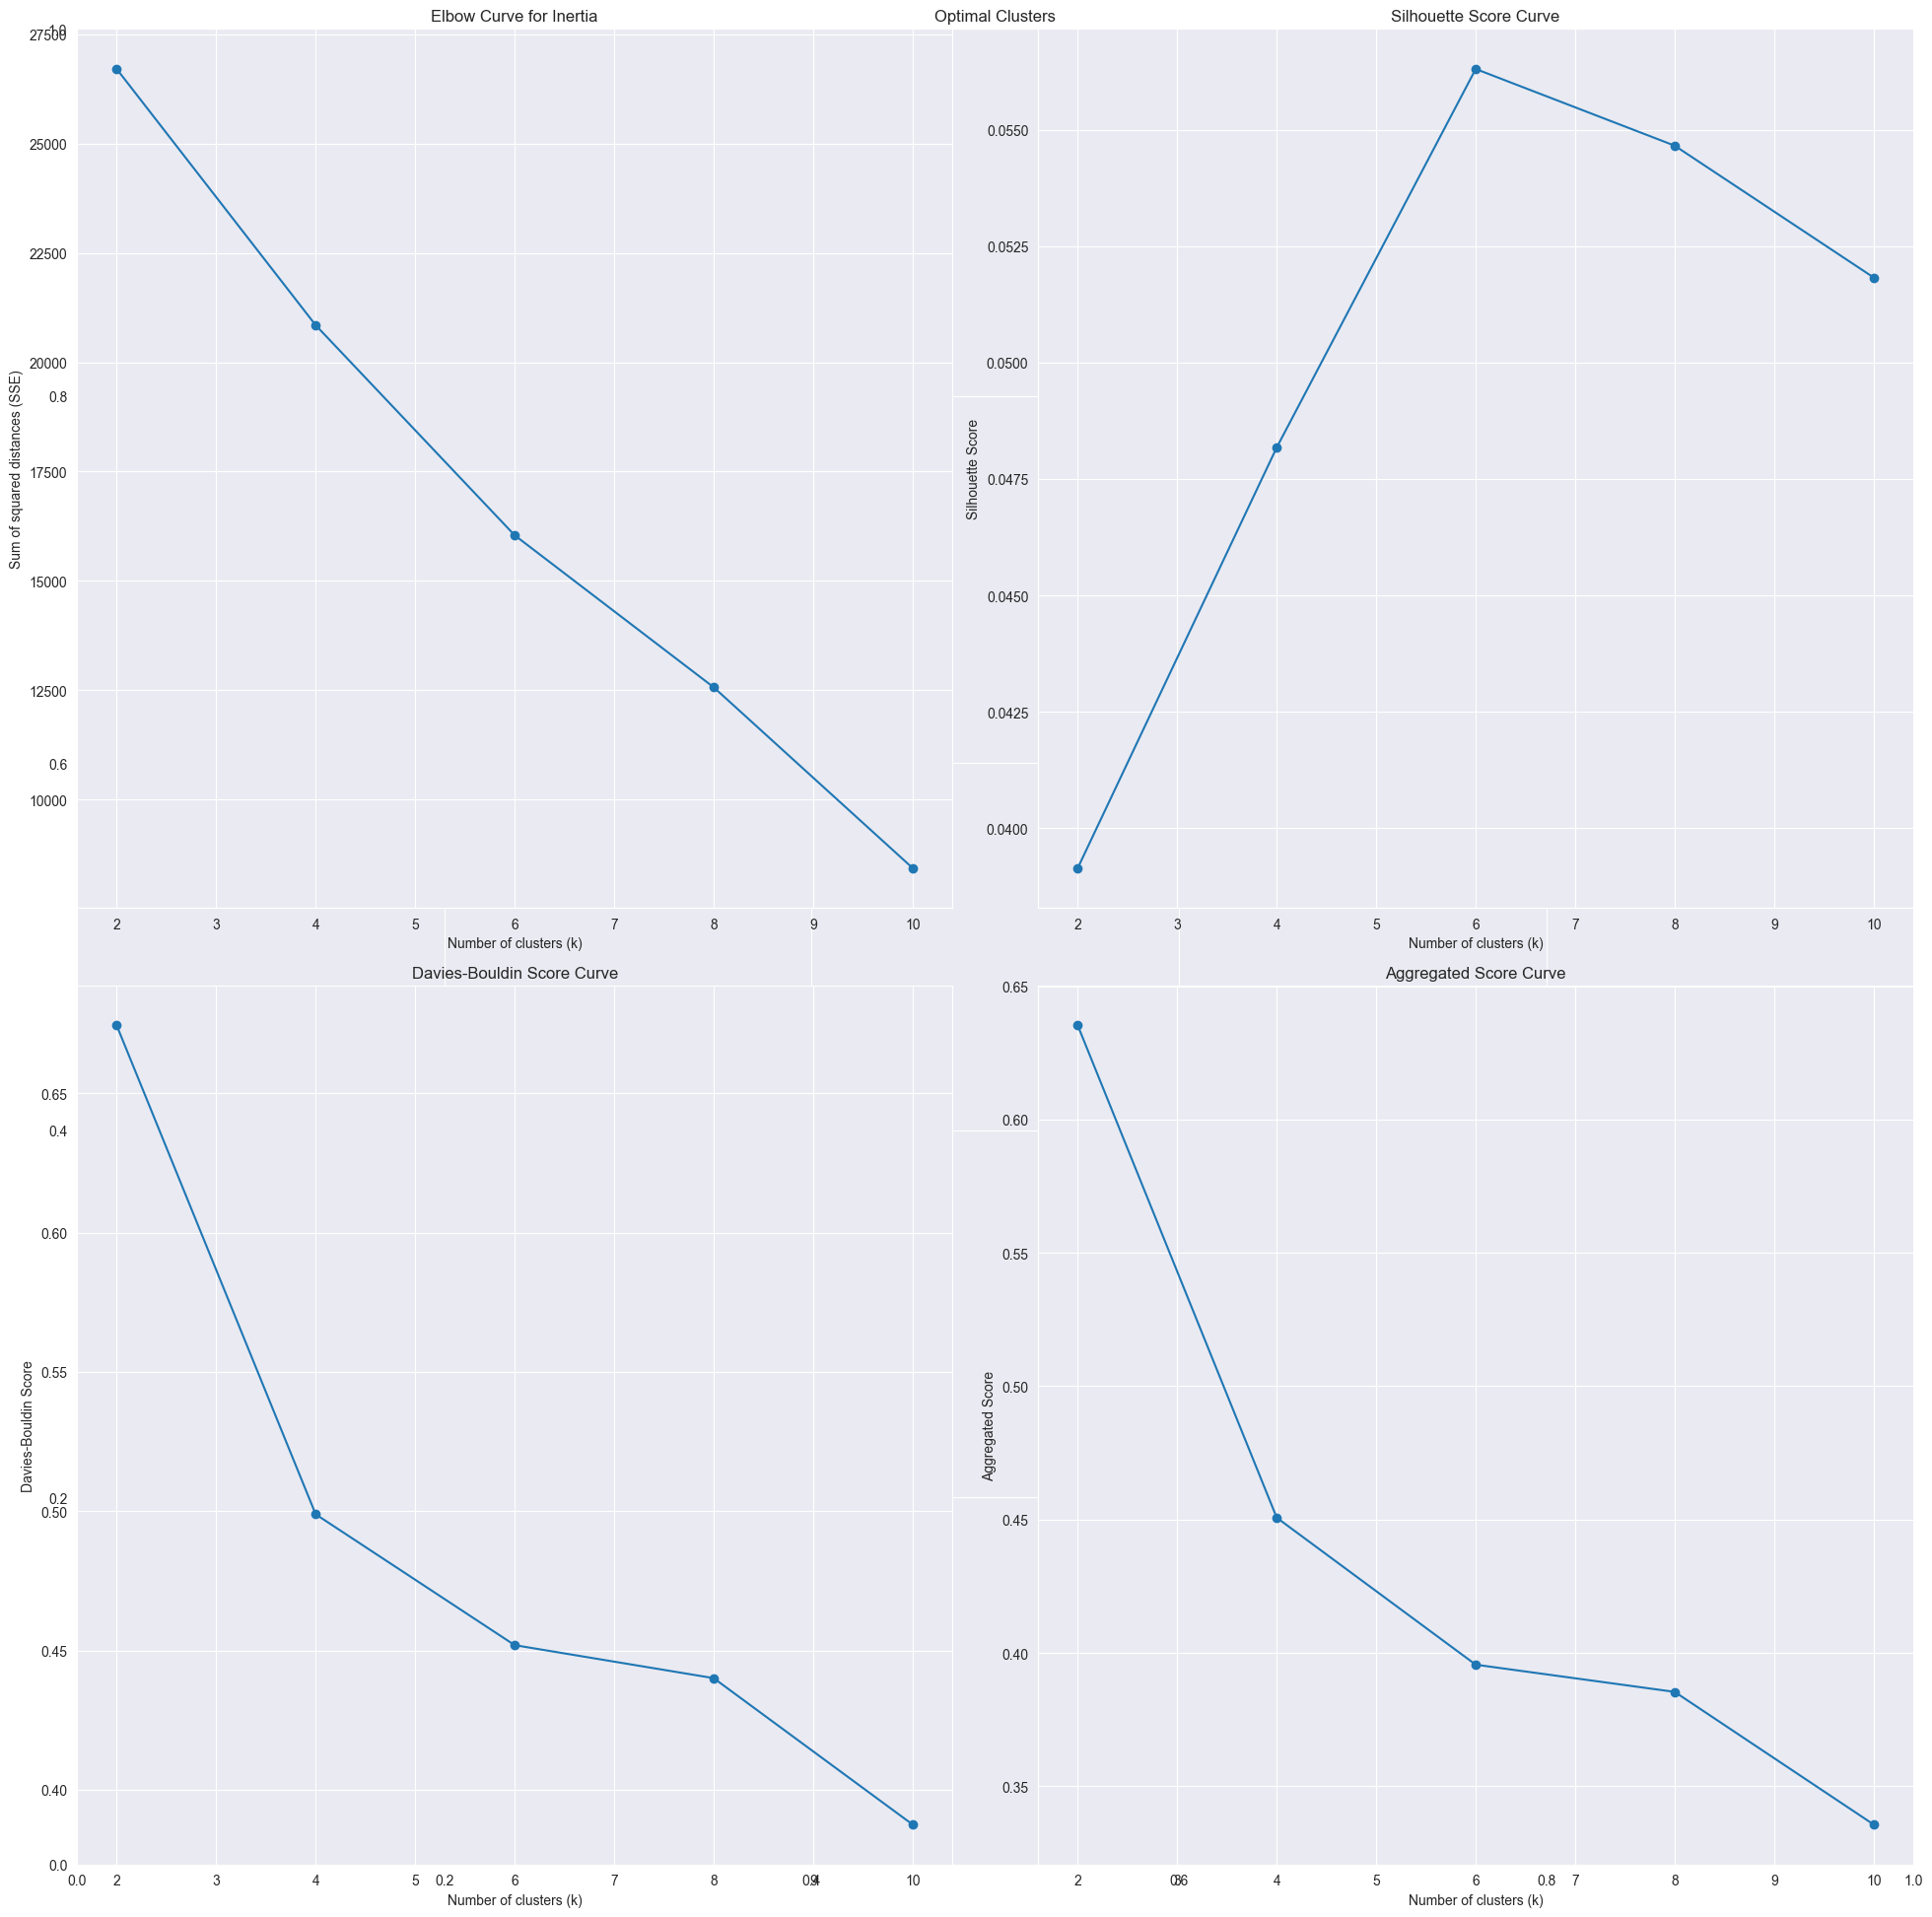

In [191]:
# Analyze the best cluster count
std_clustering_analyzer.analyze_best_cluster_count(
    'kmeans', 'vector_with_trip_feature_pca', plot_path=None, k_min=2, k_max=10, step=2
)

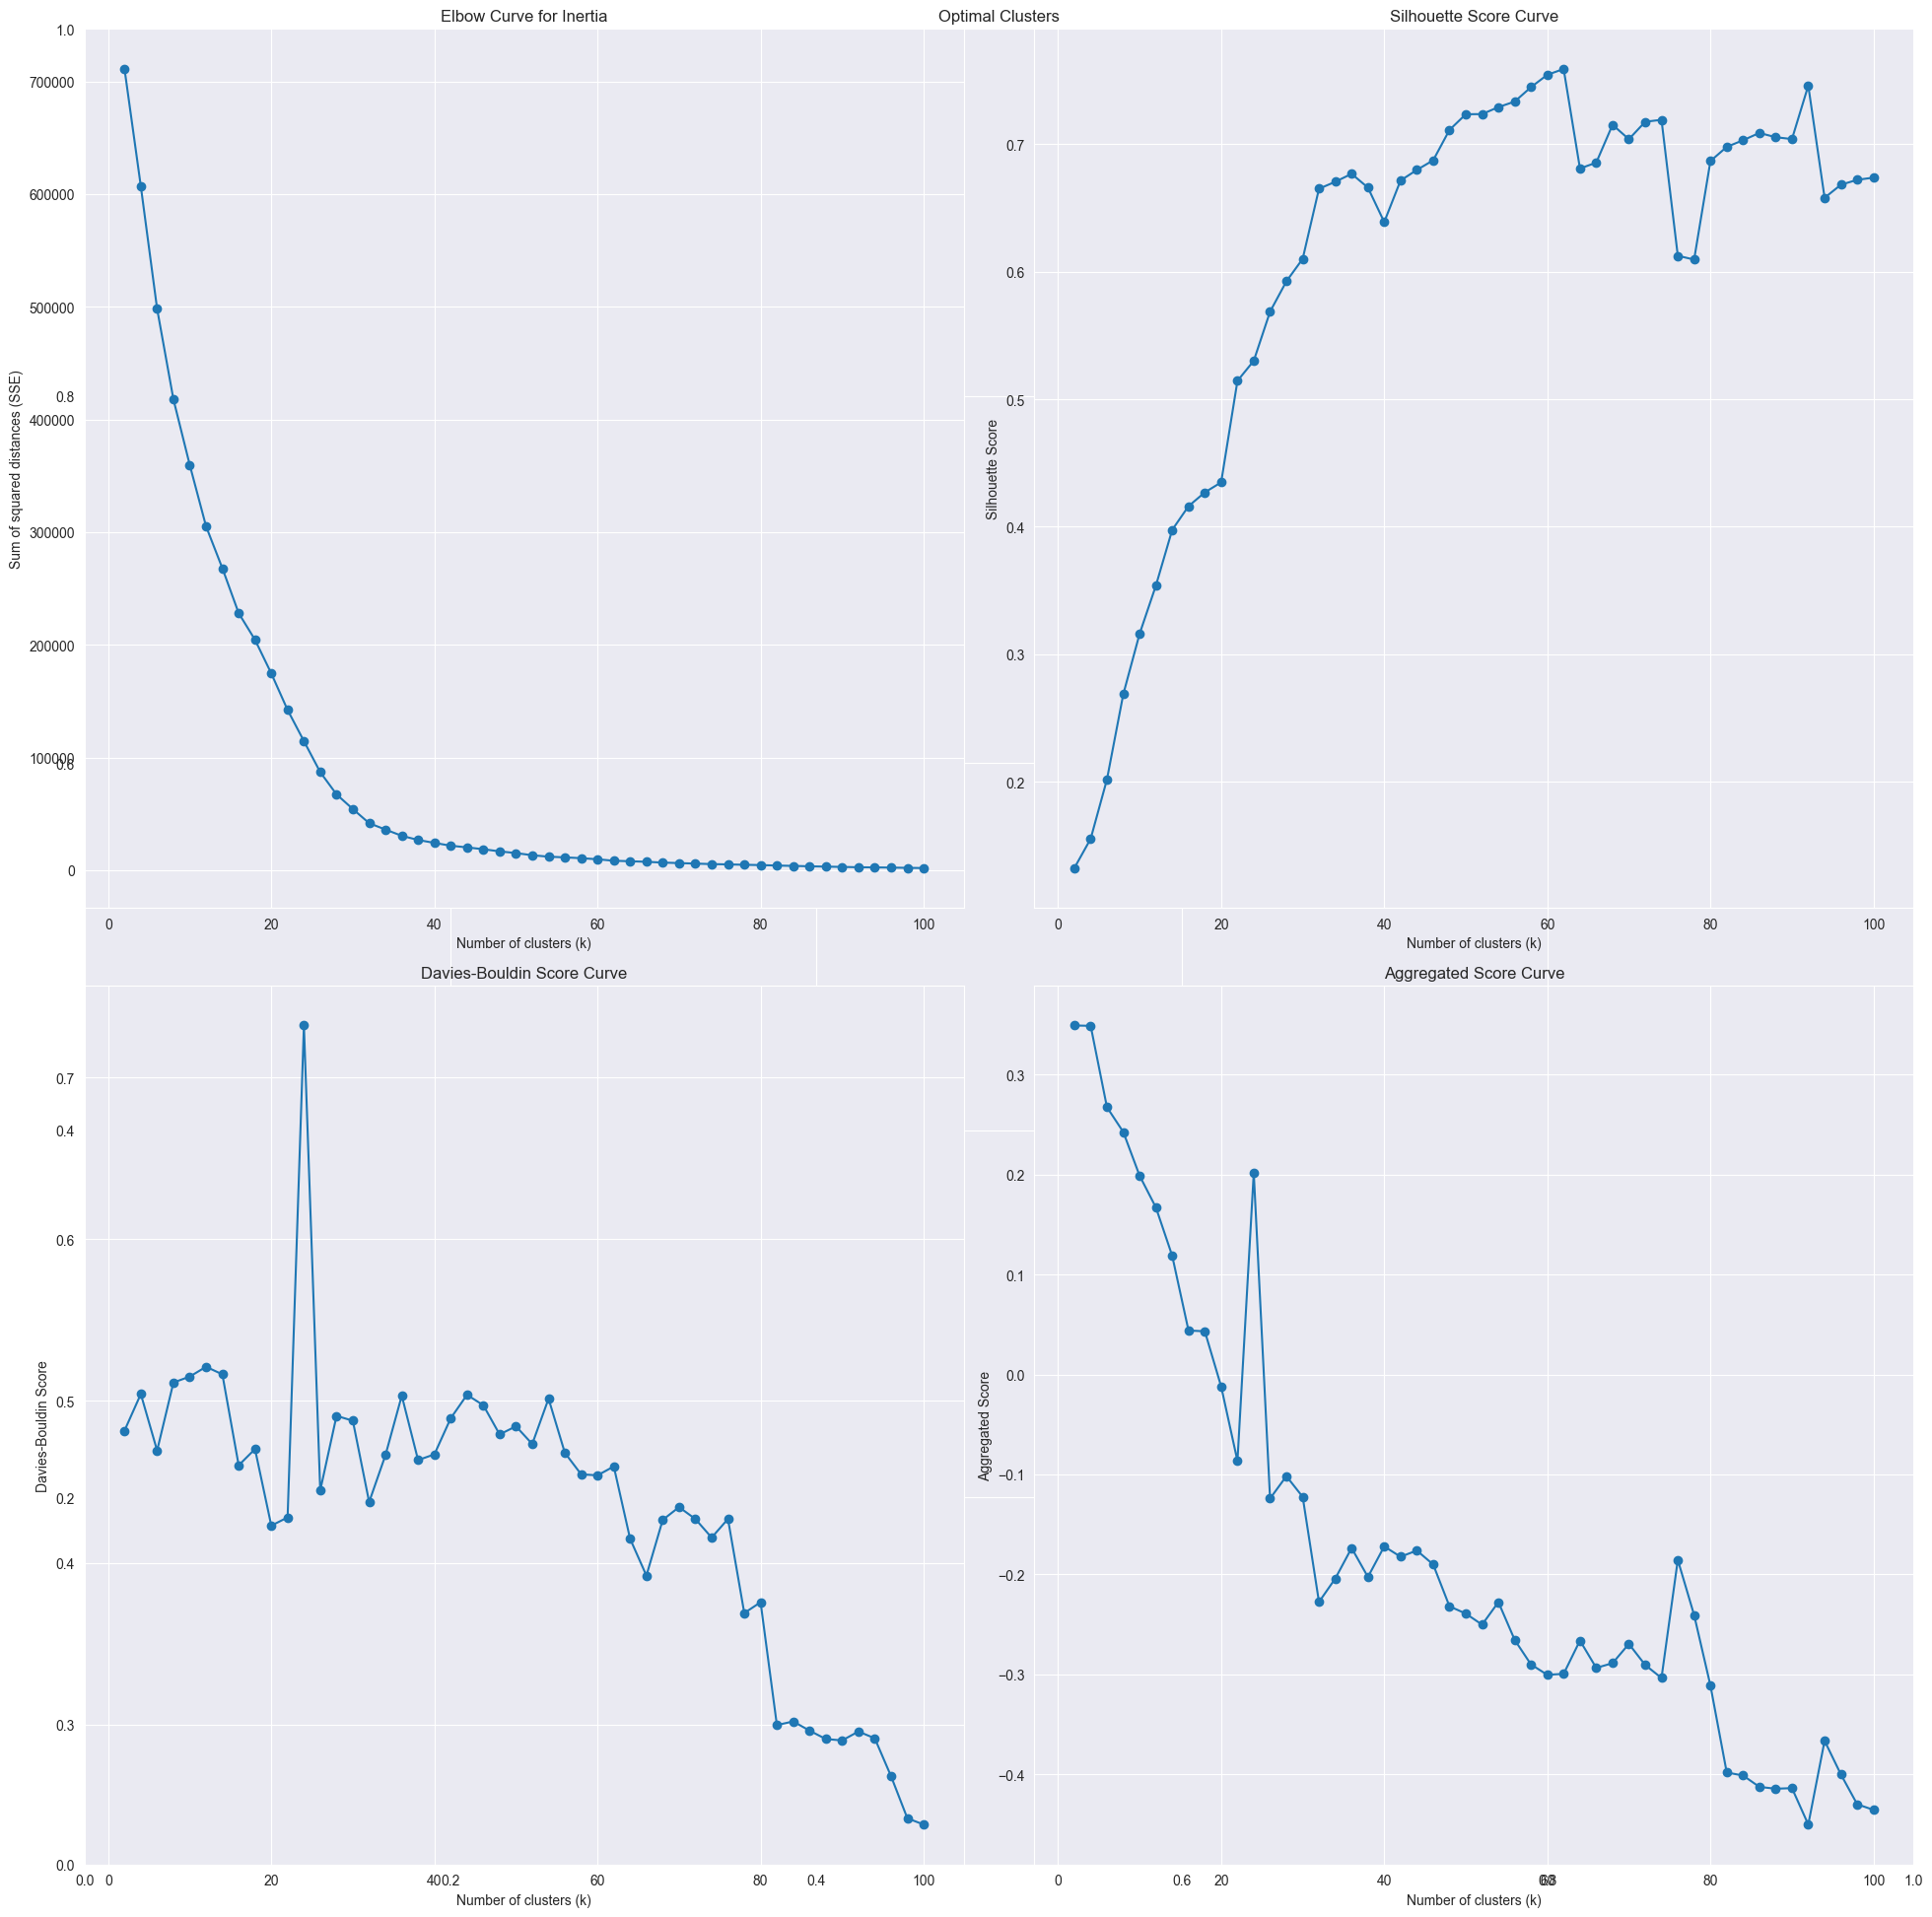

In [192]:
act_clustering_analyzer.analyze_best_cluster_count(
    'kmeans', 'vector_with_trip_feature_pca', plot_path=None, k_min=2, k_max=100, step=2
)

#### Analyzing Best Clustering Parameters

In [193]:
# Analyze clustering parameters
cluster_size = [50]

kmeans_parameters_combinations = [
    {
        'n_clusters': n_clusters, 'init': init, 'n_init': n_init,
        'tol': tol, 'max_iter': max_iter, 'algorithm': algorithm
    } 
    for n_clusters in cluster_size
    for init in ['k-means++']
    for n_init in [10, 20, 30]
    for tol in [1e-4, 1e-3, 1e-5]
    for max_iter in [200, 600, 900]
    for algorithm in ['lloyd']
]

cluster_size_kmedoids = [29]
kmedoids_parameters_combinations = [
    {
        'n_clusters': n_clusters, 'init': init, 'max_iter': max_iter, 'metric': metric, 'method': method
    } 
    for n_clusters in cluster_size_kmedoids
    for init in ['k-medoids++', 'random', 'heuristic', 'build']
    for max_iter in [300]
    for metric in ['cosine', 'euclidean']
    for method in ['alternate']
]

In [194]:
# Analyze clustering parameters on standard routes with KMeans
# Analyze clustering parameters
std_best_score, std_best_config = act_clustering_analyzer.analyze_clustering_parameters(
    'vector_with_trip_feature_pca', kmeans_parameters_combinations, enable_plot=False
)


Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 200, 'algorithm': 'lloyd'}
Silhouette score: 0.7051338112643822
Davies-Bouldin score: 0.4426503022538926

Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 600, 'algorithm': 'lloyd'}
Silhouette score: 0.7051338112643822
Davies-Bouldin score: 0.4426503022538926

Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 900, 'algorithm': 'lloyd'}
Silhouette score: 0.7051338112643822
Davies-Bouldin score: 0.4426503022538926

Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.001, 'max_iter': 200, 'algorithm': 'lloyd'}
Silhouette score: 0.7051338112643822
Davies-Bouldin score: 0.4426503022538926

Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.001, 'max_iter': 600, 'algorithm': 'lloyd'}
Silhouette score: 0.705133811264382

In [195]:
# Print the best score and configuration
print('Kmeans Clustering Parameters Analysis on Standard Routes:')
print('==> Standard Routes Analysis:')
print('\t\t * Best Score:', std_best_score)
print('\n')
print('\t\t * Best Configuration:', std_best_config)

Kmeans Clustering Parameters Analysis on Standard Routes:
==> Standard Routes Analysis:
		 * Best Score: (1.5457355816707796, 0.7051338112643822, 0.4426503022538926)


		 * Best Configuration: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 200, 'algorithm': 'lloyd'}


In [196]:
# Analyze clustering parameters on actual routes with KMeans
act_best_score, act_best_config = act_clustering_analyzer.analyze_clustering_parameters(
    'vector_with_trip_feature_pca', kmeans_parameters_combinations, enable_plot=False, cluster_type='kmeans'
)


Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 200, 'algorithm': 'lloyd'}
Silhouette score: 0.7051338112643822
Davies-Bouldin score: 0.4426503022538926

Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 600, 'algorithm': 'lloyd'}
Silhouette score: 0.7051338112643822
Davies-Bouldin score: 0.4426503022538926

Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 900, 'algorithm': 'lloyd'}
Silhouette score: 0.7051338112643822
Davies-Bouldin score: 0.4426503022538926

Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.001, 'max_iter': 200, 'algorithm': 'lloyd'}
Silhouette score: 0.7051338112643822
Davies-Bouldin score: 0.4426503022538926

Analyzing parameters: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.001, 'max_iter': 600, 'algorithm': 'lloyd'}
Silhouette score: 0.705133811264382

In [197]:
print('==> Kmeans Clustering Actual Routes Analysis on Actual Routes:')
print('\t\t * Best Score:', act_best_score)
print('\n')
print('\t\t * Best Configuration:', act_best_config)

==> Kmeans Clustering Actual Routes Analysis on Actual Routes:
		 * Best Score: (1.5457355816707796, 0.7051338112643822, 0.4426503022538926)


		 * Best Configuration: {'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 200, 'algorithm': 'lloyd'}


In [198]:
# Analyze clustering parameters with KMedoids on standard routes
std_best_score_kmedoids, std_best_config_kmedoids = std_clustering_analyzer.analyze_clustering_parameters(
    'vector_with_trip_feature_pca', kmedoids_parameters_combinations, enable_plot=False, cluster_type='kmedoids'
)


Analyzing parameters: {'n_clusters': 29, 'init': 'k-medoids++', 'max_iter': 300, 'metric': 'cosine', 'method': 'alternate'}
Silhouette score: 0.002864195959510014
Davies-Bouldin score: 0.11010764142217547

Analyzing parameters: {'n_clusters': 29, 'init': 'k-medoids++', 'max_iter': 300, 'metric': 'euclidean', 'method': 'alternate'}
Silhouette score: 0.002864195959510014
Davies-Bouldin score: 0.11010764142217547

Analyzing parameters: {'n_clusters': 29, 'init': 'random', 'max_iter': 300, 'metric': 'cosine', 'method': 'alternate'}
Silhouette score: 0.013623698669203056
Davies-Bouldin score: 0.43484356010352776

Analyzing parameters: {'n_clusters': 29, 'init': 'random', 'max_iter': 300, 'metric': 'euclidean', 'method': 'alternate'}
Silhouette score: -0.037796333606492
Davies-Bouldin score: 0.4540967687552965

Analyzing parameters: {'n_clusters': 29, 'init': 'heuristic', 'max_iter': 300, 'metric': 'cosine', 'method': 'alternate'}
Silhouette score: 0.00407262932102485
Davies-Bouldin score: 

In [199]:
# Print the best score and configuration
print('KMedoids Clustering Parameters Analysis on Standard Routes:')
print('==> Standard Routes Analysis:')
print('\t\t * Best Score:', std_best_score_kmedoids)
print('\n')
print('\t\t * Best Configuration:', std_best_config_kmedoids)

KMedoids Clustering Parameters Analysis on Standard Routes:
==> Standard Routes Analysis:
		 * Best Score: (1.4022456431589279, 0.002864195959510014, 0.11010764142217547)


		 * Best Configuration: {'n_clusters': 29, 'init': 'k-medoids++', 'max_iter': 300, 'metric': 'cosine', 'method': 'alternate'}


In [200]:
# Analyze clustering parameters with KMedoids on actual routes
act_best_score_kmedoids, act_best_config_kmedoids = act_clustering_analyzer.analyze_clustering_parameters(
    'vector_with_trip_feature_pca', kmedoids_parameters_combinations, enable_plot=False, cluster_type='kmedoids'
)


Analyzing parameters: {'n_clusters': 29, 'init': 'k-medoids++', 'max_iter': 300, 'metric': 'cosine', 'method': 'alternate'}
Silhouette score: 0.7133093805602019
Davies-Bouldin score: 0.9628029723691078

Analyzing parameters: {'n_clusters': 29, 'init': 'k-medoids++', 'max_iter': 300, 'metric': 'euclidean', 'method': 'alternate'}
Silhouette score: 0.5790478431528234
Davies-Bouldin score: 0.3666135913931164

Analyzing parameters: {'n_clusters': 29, 'init': 'random', 'max_iter': 300, 'metric': 'cosine', 'method': 'alternate'}
Silhouette score: 0.4036049511333867
Davies-Bouldin score: 1.500223610101553

Analyzing parameters: {'n_clusters': 29, 'init': 'random', 'max_iter': 300, 'metric': 'euclidean', 'method': 'alternate'}
Silhouette score: 0.10546290593257997
Davies-Bouldin score: 1.7799671440739804

Analyzing parameters: {'n_clusters': 29, 'init': 'heuristic', 'max_iter': 300, 'metric': 'cosine', 'method': 'alternate'}
Silhouette score: 0.23260456335774699
Davies-Bouldin score: 1.8644135

In [201]:
# Print the best score and configuration
print('==> KMedoids Clustering Actual Routes Analysis on Actual Routes:')
print('\t\t * Best Score:', act_best_score_kmedoids)
print('\n')
print('\t\t * Best Configuration:', act_best_config_kmedoids)

==> KMedoids Clustering Actual Routes Analysis on Actual Routes:
		 * Best Score: (1.5212596560210012, 0.5790478431528234, 0.3666135913931164)


		 * Best Configuration: {'n_clusters': 29, 'init': 'k-medoids++', 'max_iter': 300, 'metric': 'euclidean', 'method': 'alternate'}


#### Visualizing Clusters and Centroids with Best Parameters

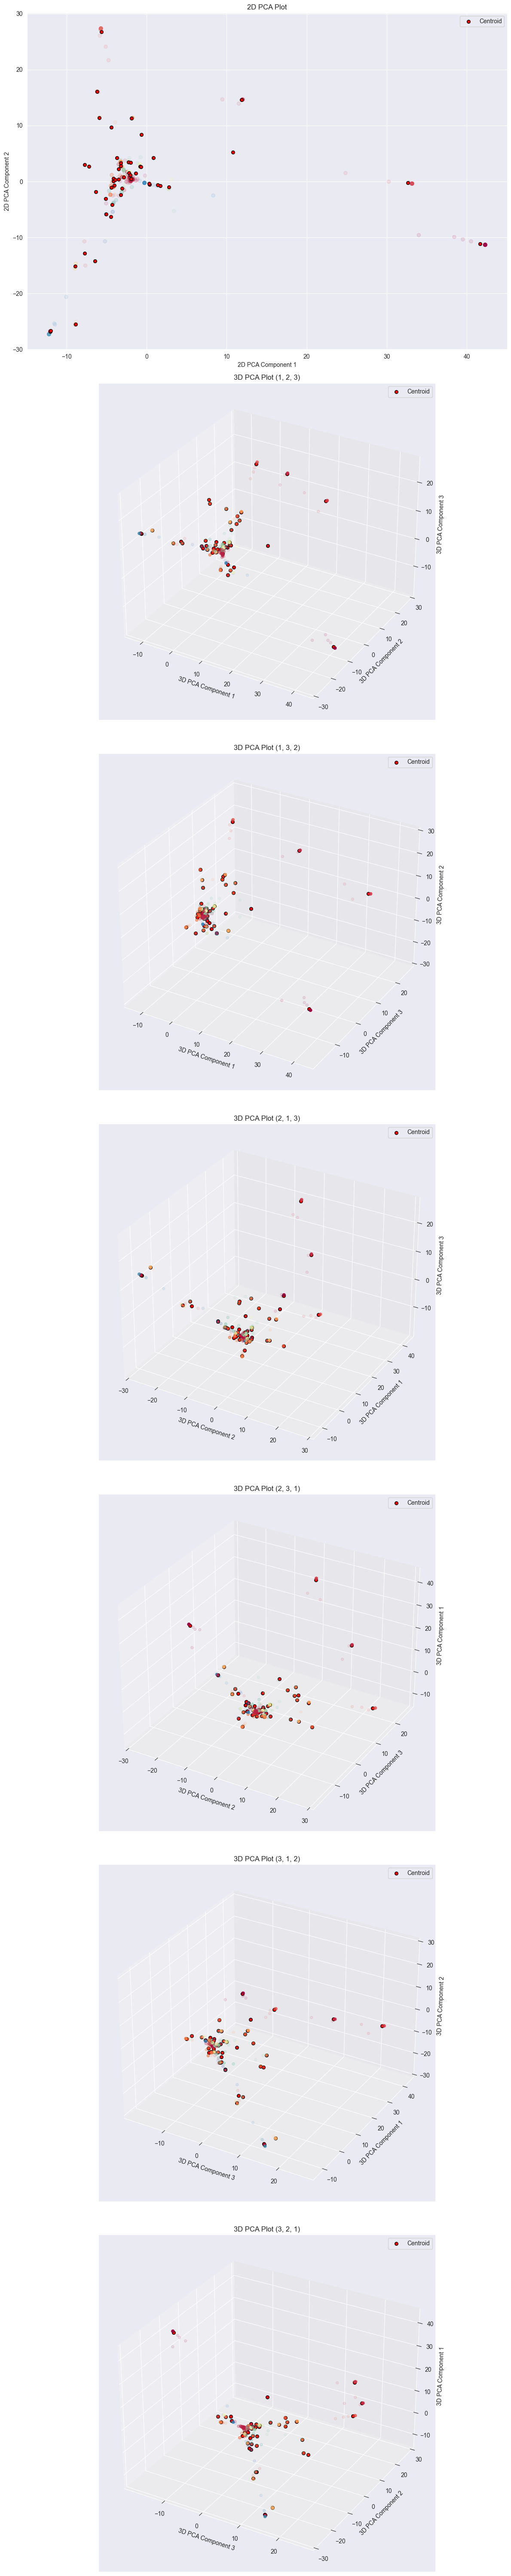

In [202]:
kmeans_parameters_combinations = {
    'n_clusters': 50, 'init': 'k-means++', 'n_init': 10, 'tol': 0.0001, 'max_iter': 200, 'algorithm': 'lloyd'
}

kmedoids_parameters_combinations = {
    'n_clusters': 29, 'init': 'k-medoids++', 'max_iter': 300, 'metric': 'cosine', 'method': 'alternate'
}

# Perform clustering with the best parameters
act_kmeans_model, act_kmeans_silhouette, act_kmeans_davies_bouldin = act_clustering_analyzer.clustering(
    'vector_with_trip_feature_pca', kmeans_parameters_combinations, cluster_type='kmeans'
)

act_kmedoids_model, act_kmedoids_silhouette, act_kmedoids_davies_bouldin = act_clustering_analyzer.clustering(
    'vector_with_trip_feature_pca', kmedoids_parameters_combinations, cluster_type='kmedoids'
)

# Visualize clusters and centroids
act_clustering_analyzer.visualize_clusters('kmeans')

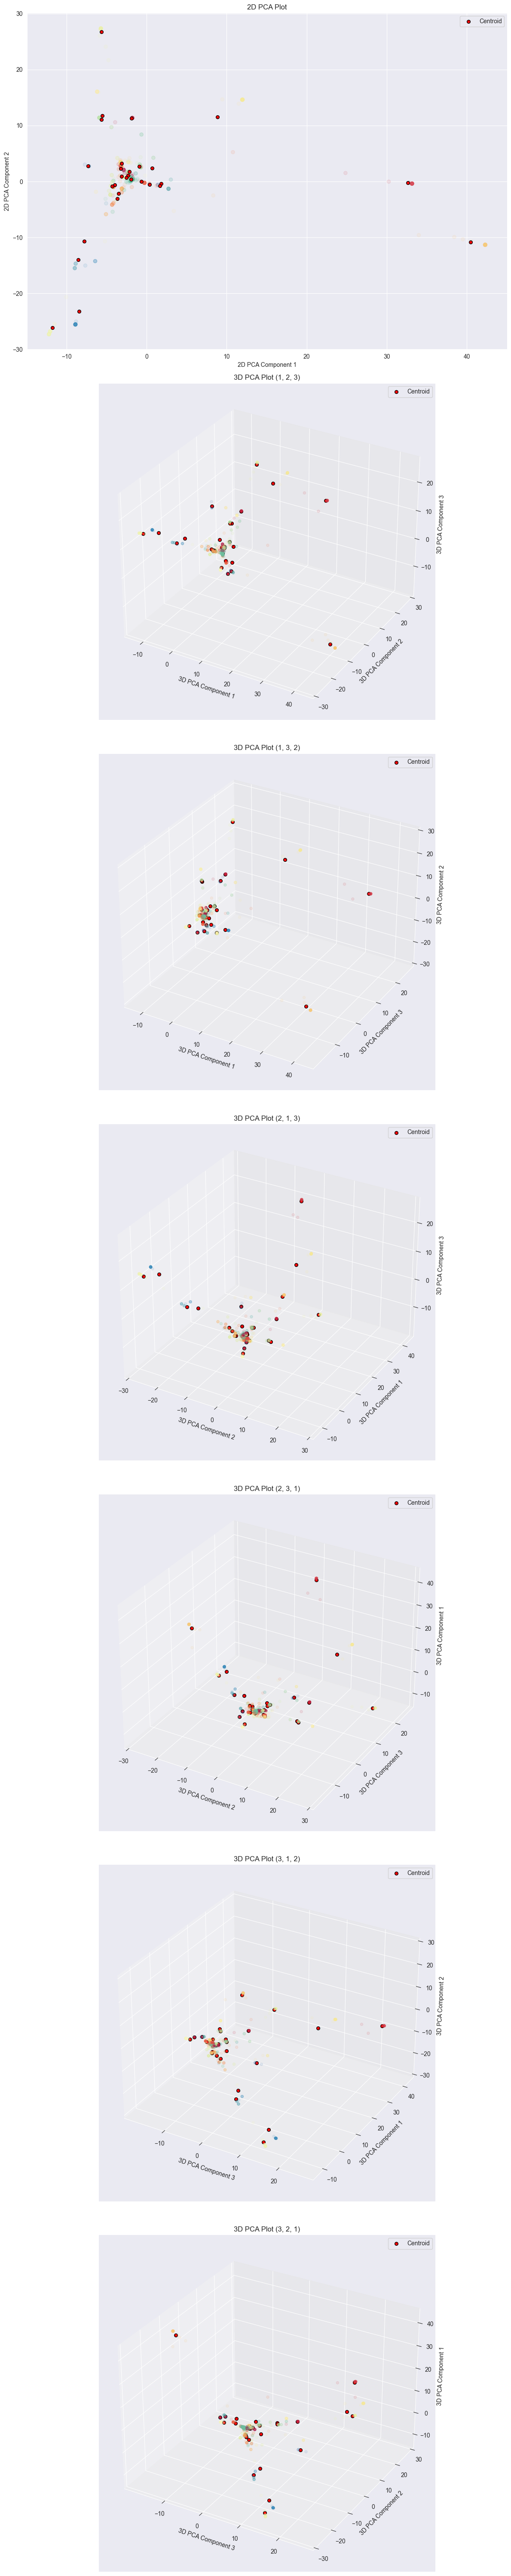

In [203]:
act_clustering_analyzer.visualize_clusters('kmedoids')

### Project Tasks

#### Task-1: Standard Routes Recommendation to Company

In [204]:
# generate recommended standard routes from kmedoids clustering
recommended_std_company_routes_kmedoids = standard_routes_recommendation_to_company(act_vectorized_routes_df, 'vectorized_routes', 'kmedoids', route_data_processor)

# generate recommended standard routes from kmeans clustering
recommended_std_company_routes_kmeans = standard_routes_recommendation_to_company(act_vectorized_routes_df, 'vectorized_routes', 'kmeans', route_data_processor)

# combine the routes from kmeans and kmedoids clustering
recommended_std_company_routes = recommended_std_company_routes_kmeans + recommended_std_company_routes_kmedoids

In [207]:
print("Recommended Standard Routes to the Company:")
print("===========================================")
print("Recommended Standard Routes (kmeans):", len(recommended_std_company_routes_kmeans))
print("Recommended Standard Routes (kmedoids):", len(recommended_std_company_routes_kmedoids))
print("Total Number of Recommended Standard Routes to the Company:", len(recommended_std_company_routes))

Recommended Standard Routes to the Company:
Recommended Standard Routes (kmeans): 50
Recommended Standard Routes (kmedoids): 29
Total Number of Recommended Standard Routes to the Company: 79


In [290]:
# save the recommended standard routes to a json file
save_routes_to_json(recommended_std_company_routes, os.path.join(DATASET_DIR, 'Generated', 'recStandard.json'))

#### Task-2: Driver Specific Standard Route Recommendations

In [279]:
RECOMMENDED_STANDARD_ROUTES_FILE = os.path.join(CWD, 'Generated', 'recStandard.json')

recommended_std_routes_df = load_and_vectorize_routes(
    RECOMMENDED_STANDARD_ROUTES_FILE, route_data_processor, routes_type='standard', normalize=True, signatures=True
)

historical_actual_routes_df = load_and_vectorize_routes(
    ACTUAL_ROUTES_PATH, route_data_processor, routes_type='actual', normalize=True, signatures=True
)

# combine the standard and actual vectorized routes
updated_routes_df = pd.merge(
    historical_actual_routes_df, 
    recommended_std_routes_df, on='s_id', how='inner', suffixes=( '_act', '_std')
)

#### Compute Similarity between Routes for Divergence Analysis and Driver-Based Route Recommendation

In [281]:
# Compute the similarity between the routes (actual + standard)
updated_routes_df['cosine_similarity'] = updated_routes_df.apply(
    lambda row: cosine_similarity(
        np.array([row['vectorized_routes_act']]),
        np.array([row['vectorized_routes_std']])
    )[0][0], axis=1
)

updated_routes_df['euclidean_similarity'] = updated_routes_df.apply(
    lambda row: euclidean_distances(
        np.array([row['vectorized_routes_act']]),
        np.array([row['vectorized_routes_std']])
    )[0][0], axis=1
)

updated_routes_df['jaccard_similarity'] = updated_routes_df.apply(
    lambda row: jaccard_similarity(row['minhash_signatures_act'], row['minhash_signatures_std']), axis=1)

updated_routes_df['similarity'] = updated_routes_df.apply(
    lambda row: (row['cosine_similarity'] + row['euclidean_similarity'] + row['jaccard_similarity']) / 3, axis=1
)

In [287]:
less_diverge_routes = compute_routes_divergence_and_recommend_top_k_less_diverge_routes(
    updated_routes_df, 'similarity', top_k=5
)

In [286]:
# remove the index column from the drivers_preferred_routes DataFrame
less_diverge_routes.sample(10)

,driver,routes
28,D8,"[s6, s4, s16, s5, s17]"
8,D3,"[s1, s20, s13, s28, s30]"
35,D26,"[s13, s8, s15, s7, s5]"
13,D5,"[s20, s11, s26, s18, s2]"
17,D40,"[s11, s12, s22, s3, s29]"
15,D47,"[s20, s13, s12, s3, s24]"
14,D19,"[s16, s21, s5, s2, s24]"
24,D29,"[s11, s25, s8, s15, s4]"
43,D22,"[s11, s13, s8, s15, s30]"
5,D35,"[s1, s11, s27, s8, s4]"


In [289]:
# Save the drivers' preferred routes to a json file with less divergence
drivers_preferred_routes_file_path = os.path.join(DATASET_DIR, 'Generated', 'drivers.json')
save_drivers_preferred_routes_to_json(less_diverge_routes, drivers_preferred_routes_file_path)

#### Task-3: Driver's Ideal Route with most least Divergence based on the Driver's Experience and Ratings

In [318]:
drivers_optimal_routes = recommend_optimal_route(predicted_ratings, route_data_processor)

In [319]:
drivers_optimal_routes[5]

{'driver': 'D6',
 'route': [{'from': 'padova',
   'to': 'venice',
   'merchandise': {'tomatoes': 12, 'milk': 28, 'water': 12}},
  {'from': 'venice',
   'to': 'vicenza',
   'merchandise': {'butter': 37,
    'tomatoes': 37,
    'coca-cola': 25,
    'bread': 28}},
  {'from': 'vicenza',
   'to': 'ravenna',
   'merchandise': {'coffee': 22,
    'sugar': 1,
    'tomatoes': 31,
    'water': 28,
    'bread': 39,
    'tea': 34,
    'milk': 46,
    'honey': 17,
    'chocolate': 1,
    'butter': 2,
    'pens': 2,
    'coca-cola': 15}},
  {'from': 'ravenna', 'to': 'modena', 'merchandise': {'butter': 17, 'tea': 9}},
  {'from': 'modena',
   'to': 'parma',
   'merchandise': {'butter': 5, 'tomatoes': 43, 'water': 40, 'milk': 45}},
  {'from': 'parma',
   'to': 'verona',
   'merchandise': {'honey': 16, 'coffee': 22, 'coca-cola': 9}},
  {'from': 'verona',
   'to': 'padova',
   'merchandise': {'water': 46, 'chocolate': 36, 'tomatoes': 30}},
  {'from': 'padova',
   'to': 'verona',
   'merchandise': {'tea': 

In [316]:
# save the drivers' optimal routes to a json file
drivers_optimal_routes_file_path = os.path.join(DATASET_DIR, 'Generated', 'perfectRoute.json')
save_routes_to_json(drivers_optimal_routes, drivers_optimal_routes_file_path)

## Tasks Evaluation

In [320]:
RECOMMENDED_STANDARD_ROUTES_FILE = os.path.join(DATASET_DIR, 'Generated', 'recStandard.json')
DRIVERS_LEAST_DIVERGENCE_TOP_K_ROUTES = os.path.join(DATASET_DIR, 'Generated', 'drivers.json')
DRIVERS_OPTIMAL_ROUTES_FILE = os.path.join(DATASET_DIR, 'Generated', 'perfectRoute.json')

#### Load the Generated Routes

In [321]:
with open(RECOMMENDED_STANDARD_ROUTES_FILE, 'r') as file:
    recommended_std_routes = json.load(file)
    
with open(DRIVERS_LEAST_DIVERGENCE_TOP_K_ROUTES, 'r') as file:
    drivers_least_divergence_routes = json.load(file)
    
with open(DRIVERS_OPTIMAL_ROUTES_FILE, 'r') as file:
    drivers_optimal_routes = json.load(file)
    
print("Recommended Standard Routes to the Company:", len(recommended_std_routes))
print("Drivers' Least Divergence Top-k Routes:", len(drivers_least_divergence_routes))
print("Drivers' Optimal Routes:", len(drivers_optimal_routes))

Recommended Standard Routes to the Company: 79
Drivers' Least Divergence Top-k Routes: 50
Drivers' Optimal Routes: 50


#### Old Standard vs Actual Routes Similarity Analysis

In [352]:
# Calculate the similarity matrix for the old standard vs actual routes
jaccard_sm = calculate_similarity_matrix(std_vectorized_routes_df[:4], act_vectorized_routes_df[:4], 'minhash_signatures', 'jaccard')

cosine_sm = calculate_similarity_matrix(std_vectorized_routes_df, act_vectorized_routes_df, 'vectorized_routes', 'cosine')

euclidean_sm = calculate_similarity_matrix(std_vectorized_routes_df, act_vectorized_routes_df, 'vectorized_routes', 'euclidean')

# Print the evaluation results
print("=====================================")
print("Jaccard Similarity Matrix:")
print("==> Shape:", jaccard_sm.shape)
print("==> Mean:", jaccard_sm.mean().round(4))
print("==> Std:", jaccard_sm.std().round(4))

print("Cosine Similarity Matrix:")
print("==> Shape:", cosine_sm.shape)
print("==> Mean:", cosine_sm.mean().round(4))
print("==> Std:", cosine_sm.std().round(4))

print("Euclidean Similarity Matrix:")
print("==> Shape:", euclidean_sm.shape)
print("==> Mean:", euclidean_sm.mean().round(4))
print("=====================================")

Jaccard Similarity Matrix:
==> Shape: (4, 4)
==> Mean: 0.5306
==> Std: 0.1216
Cosine Similarity Matrix:
==> Shape: (760, 30)
==> Mean: 0.0521
==> Std: 0.1542
Euclidean Similarity Matrix:
==> Shape: (760, 30)
==> Mean: 42.8608


In [ ]:
# Plot the similarity matrix
plot_matrix(jaccard_sm, 4, 4, 'Standard Routes', 'Actual Routes', 'Jaccard Similarity Matrix (Old Standard vs Actual Routes)')
plot_matrix(cosine_sm, 4, 4, 'Standard Routes', 'Actual Routes', 'Cosine Similarity Matrix (Old Standard vs Actual Routes)')

#### New Standard vs Actual Routes Similarity Analysis

In [354]:
# Calculate the similarity matrix for the new standard vs actual routes
jaccard_sm_recstd_act = calculate_similarity_matrix(recommended_std_routes_df, act_vectorized_routes_df, 'minhash_signatures', 'jaccard')

cosine_sm_recstd_act = calculate_similarity_matrix(recommended_std_routes_df, act_vectorized_routes_df, 'vectorized_routes', 'cosine')

euclidean_sm_recstd_act = calculate_similarity_matrix(recommended_std_routes_df, act_vectorized_routes_df, 'vectorized_routes', 'euclidean')

# Print the evaluation results
print("=====================================")
print("Jaccard Similarity Matrix:")
print("==> Shape:", jaccard_sm_recstd_act.shape)
print("==> Mean:", jaccard_sm_recstd_act.mean().round(4))
print("==> Std:", jaccard_sm_recstd_act.std().round(4))

print("Cosine Similarity Matrix:")
print("==> Shape:", cosine_sm_recstd_act.shape)
print("==> Mean:", cosine_sm_recstd_act.mean().round(4))
print("==> Std:", cosine_sm_recstd_act.std().round(4))

print("Euclidean Similarity Matrix:")
print("==> Shape:", euclidean_sm_recstd_act.shape)
print("==> Mean:", euclidean_sm_recstd_act.mean().round(4))
print("=====================================")

Jaccard Similarity Matrix:
==> Shape: (760, 79)
==> Mean: 0.5
==> Std: 0.0195
Cosine Similarity Matrix:
==> Shape: (760, 79)
==> Mean: 0.0466
==> Std: 0.1117
Euclidean Similarity Matrix:
==> Shape: (760, 79)
==> Mean: 46.6016


In [ ]:
# Plot the similarity matrix
plot_matrix(jaccard_sm, 4, 4, 'Standard Routes', 'Actual Routes', 'Jaccard Similarity Matrix (Old Standard vs Actual Routes)')
plot_matrix(cosine_sm, 4, 4, 'Standard Routes', 'Actual Routes', 'Cosine Similarity Matrix (Old Standard vs Actual Routes)')

#### Drivers' Least Divergence Top-k Routes Evaluation and Analysis